## Siemens Variance Analysis

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features
4. Filtering and spliting in Blood and aqueous groups
5. Window extraction
   - 5.1. Validating if there are partial or full missing values after the extraction
   - 5.2 Visualize the origin window intervals in different groups of Features
7. Additional Functions
   7.1. Visualization of plots with raw data after the extraction.
   7.2. Visualization of plots with data centered after the extraction.
9. Visualization of Time Series from the Windows
10. Variance Analysis
     

# 1. Loading the datasets

In [1]:
#!pip install scikit-fda

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
import numpy as np
from scipy.stats import f
from statsmodels.tsa.stattools import adfuller
from scipy.stats import levene

# 2. Transposing the time series datasets

You can change this part based on where you store the data

In [3]:
# Import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv", parse_dates=['DateTime'])

# 3. Merging time series datasets to add additional features

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [6]:
# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.

keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])
keyByTestID.head(3)

,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode,Fluid_Temperature_Filled
0,3550995,Eurotrol L1,2024-02-07 10:32:15,16-23333-20,302910,70,73,180.4,178.8,System 2A,Sensor A,21.2345,NaN,NaN,Success,NoError,NoError,Success,21.2345
1,3550995,Eurotrol L1,2024-02-07 10:32:15,16-23333-20,302910,70,73,180.4,178.8,System 2A,Sensor B,21.2345,NaN,NaN,Success,NoError,NoError,Success,21.2345
2,3551012,Eurotrol L1,2024-02-07 10:41:33,16-23333-20,303096,70,73,183.2,181.6,System 2A,Sensor A,21.5012,NaN,NaN,Success,NoError,NoError,Success,21.5012


In [7]:
keyByTestID.tail(3)

,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode,Fluid_Temperature_Filled
24255,3518677,HNB,2023-09-19 16:54:21,16-23151-20,302186,111,23,459.0,454.8,System 2A,Sensor B,25.2250,15.0,NaN,Success,NoError,NoError,Success,15.0
24256,3518678,HNB,2023-09-19 16:54:23,16-23137-20,300820,125,33,459.2,455.2,System 2A,Sensor A,24.4908,15.0,NaN,Success,NoError,NoError,Success,15.0
24257,3518678,HNB,2023-09-19 16:54:23,16-23137-20,300820,125,33,459.2,455.2,System 2A,Sensor B,24.4908,15.0,NaN,Success,NoError,NoError,Success,15.0


In [8]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3377)
A2:  (7743, 3368)
B1:  (3375, 3377)
B2:  (7745, 3368)


# 4. Filtering and spliting in Blood and Aqueous groups

In [9]:
# Blood (any distinct from Eurotrol)
A1_blood_Merged = A1_Merged[~A1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A2_blood_Merged = A2_Merged[~A2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A1_blood_Merged.reset_index(drop=True, inplace=True)
A2_blood_Merged.reset_index(drop=True, inplace=True)

# Aqueous
A1_aqueous_Merged = A1_Merged[A1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A2_aqueous_Merged = A2_Merged[A2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A1_aqueous_Merged.reset_index(drop=True, inplace=True)
A2_aqueous_Merged.reset_index(drop=True, inplace=True)

# Blood (any distinct from Eurotrol)
B1_blood_Merged = (B1_Merged[~B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_blood_Merged = (B2_Merged[~B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_blood_Merged.reset_index(drop=True, inplace=True)
B2_blood_Merged.reset_index(drop=True, inplace=True)

# Aqueous
B1_aqueous_Merged = (B1_Merged[B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_aqueous_Merged = (B2_Merged[B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_aqueous_Merged.reset_index(drop=True, inplace=True)
B2_aqueous_Merged.reset_index(drop=True, inplace=True)

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3377)
A2:  (7743, 3368)
B1:  (3375, 3377)
B2:  (7745, 3368)


# 5. Window extraction

In [10]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Match window values of Sensor B for each test

# Blood
calDelLimit_sensorB_blood = 20
sampleDelLimit_sensorB_blood = 24
calWindowSize_sensorB_blood = 18
sampleWindowSize_sensorB_blood = 4

# Aqueous
calDelLimit_sensorB_aqueous = 20
sampleDelLimit_sensorB_aqueous = 30
calWindowSize_sensorB_aqueous = 18
sampleWindowSize_sensorB_aqueous = 4

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    """
    Calculate the start and end values for calibration and sample windows. The calculation is based on given start points and delimiters for both windows, as well as the window sizes.

    Parameters:
    -----------
    bubble_start : float
        The starting point for the bubble (reference point for calibration).
    sample_start : float
        The starting point for the sample.
    calDelimit_input : float
        The delimiter value to adjust the starting point of the calibration window.
    cal_window_size_input : float
        The size of the calibration window.
    sampleDelimit_input : float
        The delimiter value to adjust the starting point of the sample window.
    sample_window_size_input : float
        The size of the sample window.

    Returns:
    --------
    tuple of float
        A tuple containing four values:
        - cal_window_start: The starting position of the calibration window, rounded to one decimal place.
        - cal_window_end: The ending position of the calibration window, rounded to one decimal place.
        - sample_window_start: The starting position of the sample window, rounded to one decimal place.
        - sample_window_end: The ending position of the sample window, rounded to one decimal place.
    """
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# Sensor A - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_blood_Merged['cal_window_start']=cal_window_start
A1_blood_Merged['cal_window_end']=cal_window_end
A1_blood_Merged['sample_window_start']=sample_window_start
A1_blood_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_blood_Merged['cal_window_start']=cal_window_start
A2_blood_Merged['cal_window_end']=cal_window_end
A2_blood_Merged['sample_window_start']=sample_window_start
A2_blood_Merged['sample_window_end']=sample_window_end


# Sensor A - aqueous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_aqueous_Merged['cal_window_start']=cal_window_start
A1_aqueous_Merged['cal_window_end']=cal_window_end
A1_aqueous_Merged['sample_window_start']=sample_window_start
A1_aqueous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_aqueous_Merged['cal_window_start']=cal_window_start
A2_aqueous_Merged['cal_window_end']=cal_window_end
A2_aqueous_Merged['sample_window_start']=sample_window_start
A2_aqueous_Merged['sample_window_end']=sample_window_end

# Sensor B - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B1_blood_Merged['cal_window_start']=cal_window_start
B1_blood_Merged['cal_window_end']=cal_window_end
B1_blood_Merged['sample_window_start']=sample_window_start
B1_blood_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end


# Sensor B - aqueous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B1_aqueous_Merged['cal_window_start']=cal_window_start
B1_aqueous_Merged['cal_window_end']=cal_window_end
B1_aqueous_Merged['sample_window_start']=sample_window_start
B1_aqueous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B2_aqueous_Merged['cal_window_start']=cal_window_start
B2_aqueous_Merged['cal_window_end']=cal_window_end
B2_aqueous_Merged['sample_window_start']=sample_window_start
B2_aqueous_Merged['sample_window_end']=sample_window_end

In [11]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    """
    Extracts calibration and sample window data from a given row of time series data.

    Parameters:
    row (pd.Series): A pandas Series object containing time series data and window start/end times.
        The Series should have the following structure:
        - 'cal_window_start': The start time for the calibration window.
        - 'cal_window_end': The end time for the calibration window.
        - 'sample_window_start': The start time for the sample window.
        - 'sample_window_end': The end time for the sample window.
        - The index from position 19 to -4 should contain the timestamps (as float) of the time series data.

    Returns:
    tuple: A tuple containing two pandas Series:
        - The first Series corresponds to the data within the calibration window.
        - The second Series corresponds to the data within the sample window.
    """
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[19:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Blood

A1_blood_cal_window = []
A1_blood_sample_window = []
for i in range(len(A1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A1_blood_Merged.iloc[i, :])
    A1_blood_cal_window.append(cal_window.values)
    A1_blood_sample_window.append(sample_window.values)
A1_blood_cal_window = pd.DataFrame(A1_blood_cal_window)
A1_blood_sample_window = pd.DataFrame(A1_blood_sample_window)
A1_blood_cal_window['TestID'] = A1_blood_sample_window['TestID'] = A1_blood_Merged['TestID']
A1_blood_sample_window.set_index('TestID',inplace=True)
A1_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - aqueous

A1_aqueous_cal_window = []
A1_aqueous_sample_window = []
for i in range(len(A1_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(A1_aqueous_Merged.iloc[i, :])
    A1_aqueous_cal_window.append(cal_window.values)
    A1_aqueous_sample_window.append(sample_window.values)
A1_aqueous_cal_window = pd.DataFrame(A1_aqueous_cal_window)
A1_aqueous_sample_window = pd.DataFrame(A1_aqueous_sample_window)
A1_aqueous_cal_window['TestID'] = A1_aqueous_sample_window['TestID'] = A1_aqueous_Merged['TestID']
A1_aqueous_sample_window.set_index('TestID',inplace=True)
A1_aqueous_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Blood

A2_blood_cal_window = []
A2_blood_sample_window = []
for i in range(len(A2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A2_blood_Merged.iloc[i, :])
    A2_blood_cal_window.append(cal_window.values)
    A2_blood_sample_window.append(sample_window.values)
A2_blood_cal_window = pd.DataFrame(A2_blood_cal_window)
A2_blood_sample_window = pd.DataFrame(A2_blood_sample_window)
A2_blood_cal_window['TestID'] = A2_blood_sample_window['TestID'] = A2_blood_Merged['TestID']
A2_blood_sample_window.set_index('TestID',inplace=True)
A2_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - aqueous

A2_aqueous_cal_window = []
A2_aqueous_sample_window = []
for i in range(len(A2_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(A2_aqueous_Merged.iloc[i, :])
    A2_aqueous_cal_window.append(cal_window.values)
    A2_aqueous_sample_window.append(sample_window.values)
A2_aqueous_cal_window = pd.DataFrame(A2_aqueous_cal_window)
A2_aqueous_sample_window = pd.DataFrame(A2_aqueous_sample_window)
A2_aqueous_cal_window['TestID'] = A2_aqueous_sample_window['TestID'] = A2_aqueous_Merged['TestID']
A2_aqueous_sample_window.set_index('TestID',inplace=True)
A2_aqueous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Blood

B1_blood_cal_window = []
B1_blood_sample_window = []
for i in range(len(B1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B1_blood_Merged.iloc[i, :])
    B1_blood_cal_window.append(cal_window.values)
    B1_blood_sample_window.append(sample_window.values)
B1_blood_cal_window = pd.DataFrame(B1_blood_cal_window)
B1_blood_sample_window = pd.DataFrame(B1_blood_sample_window)
B1_blood_cal_window['TestID'] = B1_blood_sample_window['TestID'] = B1_blood_Merged['TestID']
B1_blood_sample_window.set_index('TestID',inplace=True)
B1_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B - Blood

B2_blood_cal_window = []
B2_blood_sample_window = []
for i in range(len(B2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B2_blood_Merged.iloc[i, :])
    B2_blood_cal_window.append(cal_window.values)
    B2_blood_sample_window.append(sample_window.values)
B2_blood_cal_window = pd.DataFrame(B2_blood_cal_window)
B2_blood_sample_window = pd.DataFrame(B2_blood_sample_window)
B2_blood_cal_window['TestID'] = B2_blood_sample_window['TestID'] = B2_blood_Merged['TestID']
B2_blood_sample_window.set_index('TestID',inplace=True)
B2_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - aqueous

B1_aqueous_cal_window = []
B1_aqueous_sample_window = []
for i in range(len(B1_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(B1_aqueous_Merged.iloc[i, :])
    B1_aqueous_cal_window.append(cal_window.values)
    B1_aqueous_sample_window.append(sample_window.values)
B1_aqueous_cal_window = pd.DataFrame(B1_aqueous_cal_window)
B1_aqueous_sample_window = pd.DataFrame(B1_aqueous_sample_window)
B1_aqueous_cal_window['TestID'] = B1_aqueous_sample_window['TestID'] = B1_aqueous_Merged['TestID']
B1_aqueous_sample_window.set_index('TestID',inplace=True)
B1_aqueous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aqueous

B2_aqueous_cal_window = []
B2_aqueous_sample_window = []
for i in range(len(B2_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(B2_aqueous_Merged.iloc[i, :])
    B2_aqueous_cal_window.append(cal_window.values)
    B2_aqueous_sample_window.append(sample_window.values)
B2_aqueous_cal_window = pd.DataFrame(B2_aqueous_cal_window)
B2_aqueous_sample_window = pd.DataFrame(B2_aqueous_sample_window)
B2_aqueous_cal_window['TestID'] = B2_aqueous_sample_window['TestID'] = B2_aqueous_Merged['TestID']
B2_aqueous_sample_window.set_index('TestID',inplace=True)
B2_aqueous_cal_window.set_index('TestID',inplace=True)

## 5.1. Validating if there are partial or full missing values after the extraction

In [12]:
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_blood_cal_window_drop_index = A1_blood_cal_window.loc[A1_blood_cal_window.isna().sum(axis=1)!=0].index
A1_aqueous_cal_window_drop_index = A1_aqueous_cal_window.loc[A1_aqueous_cal_window.isna().sum(axis=1)!=0].index
A2_blood_cal_window_drop_index = A2_blood_cal_window.loc[A2_blood_cal_window.isna().sum(axis=1)!=0].index
A2_aqueous_cal_window_drop_index = A2_aqueous_cal_window.loc[A2_aqueous_cal_window.isna().sum(axis=1)!=0].index

B1_blood_cal_window_drop_index = B1_blood_cal_window.loc[B1_blood_cal_window.isna().sum(axis=1)!=0].index
B1_aqueous_cal_window_drop_index = B1_aqueous_cal_window.loc[B1_aqueous_cal_window.isna().sum(axis=1)!=0].index
B2_blood_cal_window_drop_index = B2_blood_cal_window.loc[B2_blood_cal_window.isna().sum(axis=1)!=0].index
B2_aqueous_cal_window_drop_index = B2_aqueous_cal_window.loc[B2_aqueous_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

A1_blood_sample_window_drop_index = A1_blood_sample_window.loc[A1_blood_sample_window.isna().sum(axis=1)!=0].index
A1_aqueous_sample_window_drop_index = A1_aqueous_sample_window.loc[A1_aqueous_sample_window.isna().sum(axis=1)!=0].index
A2_blood_sample_window_drop_index = A2_blood_sample_window.loc[A2_blood_sample_window.isna().sum(axis=1)!=0].index
A2_aqueous_sample_window_drop_index = A2_aqueous_sample_window.loc[A2_aqueous_sample_window.isna().sum(axis=1)!=0].index

B1_blood_sample_window_drop_index = B1_blood_sample_window.loc[B1_blood_sample_window.isna().sum(axis=1)!=0].index
B1_aqueous_sample_window_drop_index = B1_aqueous_sample_window.loc[B1_aqueous_sample_window.isna().sum(axis=1)!=0].index
B2_blood_sample_window_drop_index = B2_blood_sample_window.loc[B2_blood_sample_window.isna().sum(axis=1)!=0].index
B2_aqueous_sample_window_drop_index = B2_aqueous_sample_window.loc[B2_aqueous_sample_window.isna().sum(axis=1)!=0].index

# Check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_blood_cal_window_drop_index)
print("The missing value in sample window:",B1_blood_sample_window_drop_index)
print("The missing value in calibration window:",B2_blood_cal_window_drop_index)
print("The missing value in sample window:",B2_blood_sample_window_drop_index)

The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')


In [13]:
# Shape of the subsets of time series after the extraction from the windows

# Cal Window
print('Shape of the time series after extraction')
print('A1_blood_cal_window: ', A1_blood_cal_window.shape)
print('A1_aqueous_cal_window: ', A1_aqueous_cal_window.shape)
print('A2_blood_cal_window: ', A2_blood_cal_window.shape)
print('A2_aqueous_cal_window: ', A2_aqueous_cal_window.shape)
print('B1_blood_cal_window: ', B1_blood_cal_window.shape)
print('B1_aqueous_cal_window: ', B1_aqueous_cal_window.shape)
print('B2_blood_cal_window: ', B2_blood_cal_window.shape)
print('B2_aqueous_cal_window: ', B2_aqueous_cal_window.shape)

# Sample Window
print('A1_blood_sample_window: ', A1_blood_sample_window.shape)
print('A1_aqueous_sample_window: ', A1_aqueous_sample_window.shape)
print('A2_blood_sample_window: ', A2_blood_sample_window.shape)
print('A2_aqueous_sample_window: ', A2_aqueous_sample_window.shape)
print('B1_blood_sample_window: ', B1_blood_sample_window.shape)
print('B1_aqueous_sample_window: ', B1_aqueous_sample_window.shape)
print('B2_blood_sample_window: ', B2_blood_sample_window.shape)
print('B2_aqueous_sample_window: ', B2_aqueous_sample_window.shape)

Shape of the time series after extraction
A1_blood_cal_window:  (1433, 41)
A1_aqueous_cal_window:  (1949, 41)
A2_blood_cal_window:  (2851, 41)
A2_aqueous_cal_window:  (4892, 41)
B1_blood_cal_window:  (1431, 91)
B1_aqueous_cal_window:  (1944, 91)
B2_blood_cal_window:  (2852, 91)
B2_aqueous_cal_window:  (4893, 91)
A1_blood_sample_window:  (1433, 26)
A1_aqueous_sample_window:  (1949, 26)
A2_blood_sample_window:  (2851, 26)
A2_aqueous_sample_window:  (4892, 26)
B1_blood_sample_window:  (1431, 21)
B1_aqueous_sample_window:  (1944, 21)
B2_blood_sample_window:  (2852, 21)
B2_aqueous_sample_window:  (4893, 21)


# Variance Analysis

- A system with lower variance tends to have flatter or smoother waveforms.

### Assumptions

- Stationarity (Augmented Dickey-Fuller Test)
    * H0: The time series is non-stationary. 
      This means that the time series has some form of trend, and its statistical properties (like mean and variance) change over time.

    * H1: The time series is stationary.
      This means that the time series does not have a trend, and its statistical properties (like mean and variance) remain constant over time.

    * If the p-value is < alpha: Reject the null hypothesis. This suggests that the time series is stationary.
    * If the p-value is > alpha: Fail to reject the null hypothesis. This suggests that the time series is non-stationary.
    
- Independence (**autocorrelation between observation within a time series**)

   *  **If this assumption does not hold, what other metrics can be use to compare flatness of time series?**
   *  **Do other metrics need independence assumption?**
     
  
- Good Sample Size (All datasets over 1,000 tests)

### Preprocessing

- Outliers: No (Remove unsuccesful tests)
- Equal length: Yes (comparison after the extraction)
- Missing Values: No (all the waveforms have the same lenth after the extraction and no missing values)


### Methods 

- 1. Direct computation  of the variances by row and then comparison of the average of the variances for each system.
      * Does not provide any measure of uncertainty around these estimates.
      * Single point estimate for the mean variance of each system, without information on the stability or variability of this estimate.
      * Assumes that the sample mean variance is a good estimator of the population variance. However, this assumption may not hold if the data is not normally distributed or if the sample size is small.
    
- 2. Bootstrap (simulating new datasets from our original data, by taking samples of 1000 test run computing their variance and then putting back)
     * Generate confidence intervals for the mean variance, giving you a sense of the variability and reliability of your estimates because provide insights into how the variance might change with different samples, making the results more robust.
     * We use 95% CI (if we were to repeat our study many times, 95% of the time, the true value we are estimating would fall within this range). 
     * Bootstrapping is a non-parametric method that does not rely on assumptions about the underlying distribution of the data or small sample sizes.


# Zero start + Differenciation

- Aligning the data (Zero start): Moving all the time series to the same starting point.
- Differencing: A method for removing trends in time series. This is the process subtracting the value of one observation with the value of another observation x number of periods ago.

In [14]:
# Cal Window
# Zero Start
A1_blood_cal_window_zero = A1_blood_cal_window.iloc[:, 1:].sub(A1_blood_cal_window.iloc[:, 1], axis=0)
A2_blood_cal_window_zero = A2_blood_cal_window.iloc[:, 1:].sub(A2_blood_cal_window.iloc[:, 1], axis=0)
A1_aqueous_cal_window_zero = A1_aqueous_cal_window.iloc[:, 1:].sub(A1_aqueous_cal_window.iloc[:, 1], axis=0)
A2_aqueous_cal_window_zero = A2_aqueous_cal_window.iloc[:, 1:].sub(A2_aqueous_cal_window.iloc[:, 1], axis=0)

B1_blood_cal_window_zero = B1_blood_cal_window.iloc[:, 1:].sub(B1_blood_cal_window.iloc[:, 1], axis=0)
B2_blood_cal_window_zero = B2_blood_cal_window.iloc[:, 1:].sub(B2_blood_cal_window.iloc[:, 1], axis=0)
B1_aqueous_cal_window_zero = B1_aqueous_cal_window.iloc[:, 1:].sub(B1_aqueous_cal_window.iloc[:, 1], axis=0)
B2_aqueous_cal_window_zero = B2_aqueous_cal_window.iloc[:, 1:].sub(B2_aqueous_cal_window.iloc[:, 1], axis=0)

# Differentiate the zero time series along the columns (axis=1)
A1_blood_cal_window_NormDiff = A1_blood_cal_window_zero.diff(axis=1).fillna(0)
A2_blood_cal_window_NormDiff = A2_blood_cal_window_zero.diff(axis=1).fillna(0)
A1_aqueous_cal_window_NormDiff = A1_aqueous_cal_window_zero.diff(axis=1).fillna(0)
A2_aqueous_cal_window_NormDiff = A2_aqueous_cal_window_zero.diff(axis=1).fillna(0)

B1_blood_cal_window_NormDiff = B1_blood_cal_window_zero.diff(axis=1).fillna(0)
B2_blood_cal_window_NormDiff = B2_blood_cal_window_zero.diff(axis=1).fillna(0)
B1_aqueous_cal_window_NormDiff = B1_aqueous_cal_window_zero.diff(axis=1).fillna(0)
B2_aqueous_cal_window_NormDiff = B2_aqueous_cal_window_zero.diff(axis=1).fillna(0)

In [15]:
# Sample Window
# Normalize the time series by subtracting the mean of each row
A1_blood_sample_window_zero = A1_blood_sample_window.iloc[:, 1:].sub(A1_blood_sample_window.iloc[:, 1], axis=0)
A2_blood_sample_window_zero = A2_blood_sample_window.iloc[:, 1:].sub(A2_blood_sample_window.iloc[:, 1], axis=0)
A1_aqueous_sample_window_zero = A1_aqueous_sample_window.iloc[:, 1:].sub(A1_aqueous_sample_window.iloc[:, 1], axis=0)
A2_aqueous_sample_window_zero = A2_aqueous_sample_window.iloc[:, 1:].sub(A2_aqueous_sample_window.iloc[:, 1], axis=0)

B1_blood_sample_window_zero = B1_blood_sample_window.iloc[:, 1:].sub(B1_blood_sample_window.iloc[:, 1], axis=0)
B2_blood_sample_window_zero = B2_blood_sample_window.iloc[:, 1:].sub(B2_blood_sample_window.iloc[:, 1], axis=0)
B1_aqueous_sample_window_zero = B1_aqueous_sample_window.iloc[:, 1:].sub(B1_aqueous_sample_window.iloc[:, 1], axis=0)
B2_aqueous_sample_window_zero = B2_aqueous_sample_window.iloc[:, 1:].sub(B2_aqueous_sample_window.iloc[:, 1], axis=0)

# Differentiate the zero time series along the columns (axis=1)
A1_blood_sample_window_NormDiff = A1_blood_sample_window_zero.diff(axis=1).fillna(0)
A2_blood_sample_window_NormDiff = A2_blood_sample_window_zero.diff(axis=1).fillna(0)
A1_aqueous_sample_window_NormDiff = A1_aqueous_sample_window_zero.diff(axis=1).fillna(0)
A2_aqueous_sample_window_NormDiff = A2_aqueous_sample_window_zero.diff(axis=1).fillna(0)

B1_blood_sample_window_NormDiff = B1_blood_sample_window_zero.diff(axis=1).fillna(0)
B2_blood_sample_window_NormDiff = B2_blood_sample_window_zero.diff(axis=1).fillna(0)
B1_aqueous_sample_window_NormDiff = B1_aqueous_sample_window_zero.diff(axis=1).fillna(0)
B2_aqueous_sample_window_NormDiff = B2_aqueous_sample_window_zero.diff(axis=1).fillna(0)

In [16]:
A1_blood_cal_window.head(1)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
TestID,,,,,,,,,,,,,,,,,,,,,
12414372,65.66079,65.64918,65.66675,65.6459,65.68105,65.66257,65.66079,65.67569,65.67271,65.6593,...,65.69745,65.70907,65.69328,65.68433,65.69506,65.70519,65.7049,65.72159,65.69864,65.71712


In [17]:
A1_blood_cal_window_zero.head(1)

,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
TestID,,,,,,,,,,,,,,,,,,,,,
12414372,0.0,0.01757,-0.00328,0.03187,0.01339,0.01161,0.02651,0.02353,0.01012,0.02263,...,0.04827,0.05989,0.0441,0.03515,0.04588,0.05601,0.05572,0.07241,0.04946,0.06794


In [18]:
A1_blood_cal_window_NormDiff.head(1)

,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
TestID,,,,,,,,,,,,,,,,,,,,,
12414372,0.0,0.01757,-0.02085,0.03515,-0.01848,-0.00178,0.0149,-0.00298,-0.01341,0.01251,...,0.00746,0.01162,-0.01579,-0.00895,0.01073,0.01013,-0.00029,0.01669,-0.02295,0.01848


<Axes: >

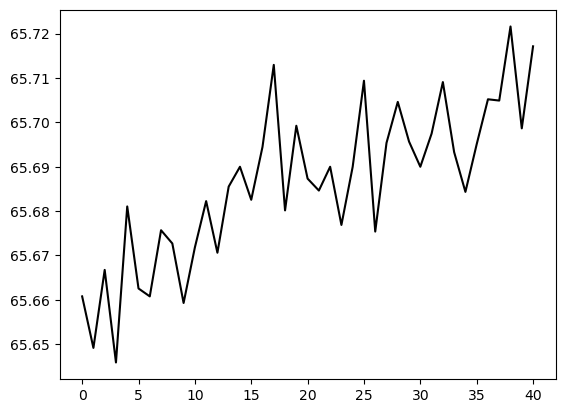

In [19]:
A1_blood_cal_window.iloc[0].plot(color='black')

<Axes: >

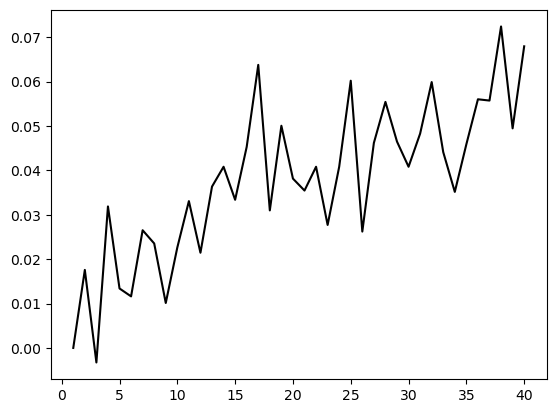

In [20]:
A1_blood_cal_window_zero.iloc[0].plot(color='black')

<Axes: >

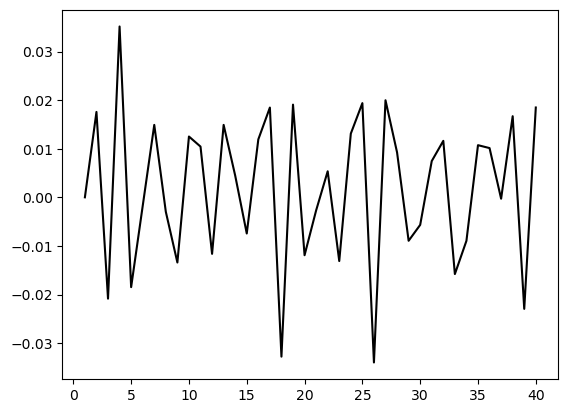

In [21]:
A1_blood_cal_window_NormDiff.iloc[0].plot(color='black')

# Stationarity

In [22]:
def adf_test_for_dataframe(data_df, significance_level=0.05):
    """
    Perform Augmented Dickey-Fuller (ADF) test on each time series in the DataFrame.

    Parameters:
    - data_df: DataFrame containing time series data where each row is a different time series.
    - significance_level: Significance level for the ADF test.

    Returns:
    - adf_results: DataFrame containing the ADF statistics, p-values, and stationary indication for each time series.
    """

    # Create a DataFrame to store the results
    adf_results = pd.DataFrame(columns=['ADF Statistic', 'p-value', 'Stationary'])

    # Iterate over rows in the DataFrame
    for idx, row in data_df.iterrows():
        # Extract the time series data from the row
        time_series_data = row.values

        # Perform the ADF test
        result = adfuller(time_series_data)

        # Determine if the time series is stationary based on the p-value
        stationary = 'Yes' if result[1] < significance_level else 'No'

        # Store the results
        adf_results.loc[idx] = [result[0], result[1], stationary]

    return adf_results

### Check stationarity: Raw Data

In [23]:
# Cal Window
adf_A1_blood_cal_window = adf_test_for_dataframe(A1_blood_cal_window)
print(adf_A1_blood_cal_window['Stationary'].value_counts())
adf_A2_blood_cal_window = adf_test_for_dataframe(A2_blood_cal_window)
print(adf_A2_blood_cal_window['Stationary'].value_counts())

No     1368
Yes      65
Name: Stationary, dtype: int64
No     2704
Yes     147
Name: Stationary, dtype: int64


In [24]:
# Sample Window
adf_A1_blood_sample_window = adf_test_for_dataframe(A1_blood_sample_window)
print(adf_A1_blood_sample_window['Stationary'].value_counts())
adf_A2_blood_sample_window = adf_test_for_dataframe(A2_blood_sample_window)
print(adf_A2_blood_sample_window['Stationary'].value_counts())

No     1348
Yes      85
Name: Stationary, dtype: int64
No     2344
Yes     507
Name: Stationary, dtype: int64


### Check stationarity: Norm + Diff Data

In [25]:
# Cal Window
print('A1_blood_cal_window_NormDiff\n')
adf_A1_blood_cal_window_NormDiff = adf_test_for_dataframe(A1_blood_cal_window_NormDiff)
print(adf_A1_blood_cal_window_NormDiff['Stationary'].value_counts())
print('\nA2_blood_cal_window_NormDiff\n')
adf_A2_blood_cal_window_NormDiff = adf_test_for_dataframe(A2_blood_cal_window_NormDiff)
print(adf_A2_blood_cal_window_NormDiff['Stationary'].value_counts())

print('\nA1_aqueous_cal_window_NormDiff\n')
adf_A1_aqueous_cal_window_NormDiff = adf_test_for_dataframe(A1_aqueous_cal_window_NormDiff)
print(adf_A1_aqueous_cal_window_NormDiff['Stationary'].value_counts())
print('\nA2_aqueous_cal_window_NormDiff\n')
adf_A2_aqueous_cal_window_NormDiff = adf_test_for_dataframe(A2_aqueous_cal_window_NormDiff)
print(adf_A2_aqueous_cal_window_NormDiff['Stationary'].value_counts())

print('\nB1_blood_cal_window_NormDiff\n')
adf_B1_blood_cal_window_NormDiff = adf_test_for_dataframe(B1_blood_cal_window_NormDiff)
print(adf_B1_blood_cal_window_NormDiff['Stationary'].value_counts())
print('\nB2_blood_cal_window_NormDiff\n')
adf_B2_blood_cal_window_NormDiff = adf_test_for_dataframe(B2_blood_cal_window_NormDiff)
print(adf_B2_blood_cal_window_NormDiff['Stationary'].value_counts())

print('\nB1_aqueous_cal_window_NormDiff\n')
adf_B1_aqueous_cal_window_NormDiff = adf_test_for_dataframe(B1_aqueous_cal_window_NormDiff)
print(adf_B1_aqueous_cal_window_NormDiff['Stationary'].value_counts())
print('\nB2_aqueous_cal_window_NormDiff\n')
adf_B2_aqueous_cal_window_NormDiff = adf_test_for_dataframe(B2_aqueous_cal_window_NormDiff)
print(adf_B2_aqueous_cal_window_NormDiff['Stationary'].value_counts())

A1_blood_cal_window_NormDiff

Yes    1361
No       72
Name: Stationary, dtype: int64

A2_blood_cal_window_NormDiff

Yes    2600
No      251
Name: Stationary, dtype: int64

A1_aqueous_cal_window_NormDiff

Yes    1839
No      110
Name: Stationary, dtype: int64

A2_aqueous_cal_window_NormDiff

Yes    4527
No      365
Name: Stationary, dtype: int64

B1_blood_cal_window_NormDiff

Yes    1288
No      143
Name: Stationary, dtype: int64

B2_blood_cal_window_NormDiff

Yes    1999
No      853
Name: Stationary, dtype: int64

B1_aqueous_cal_window_NormDiff

Yes    1780
No      164
Name: Stationary, dtype: int64

B2_aqueous_cal_window_NormDiff

Yes    3448
No     1445
Name: Stationary, dtype: int64


In [26]:
# Sample Window
print('A1_blood_sample_window_NormDiff\n')
adf_A1_blood_sample_window_NormDiff = adf_test_for_dataframe(A1_blood_sample_window_NormDiff)
print(adf_A1_blood_sample_window_NormDiff['Stationary'].value_counts())
print('\nA2_blood_sample_window_NormDiff\n')
adf_A2_blood_sample_window_NormDiff = adf_test_for_dataframe(A2_blood_sample_window_NormDiff)
print(adf_A2_blood_sample_window_NormDiff['Stationary'].value_counts())

print('\nA1_aqueous_sample_window_NormDiff\n')
adf_A1_aqueous_sample_window_NormDiff = adf_test_for_dataframe(A1_aqueous_sample_window_NormDiff)
print(adf_A1_aqueous_sample_window_NormDiff['Stationary'].value_counts())
print('\nA2_aqueous_sample_window_NormDiff\n')
adf_A2_aqueous_sample_window_NormDiff = adf_test_for_dataframe(A2_aqueous_sample_window_NormDiff)
print(adf_A2_aqueous_sample_window_NormDiff['Stationary'].value_counts())

print('\nB1_blood_sample_window_NormDiff\n')
adf_B1_blood_sample_window_NormDiff = adf_test_for_dataframe(B1_blood_sample_window_NormDiff)
print(adf_B1_blood_sample_window_NormDiff['Stationary'].value_counts())
print('\nB2_blood_sample_window_NormDiff\n')
adf_B2_blood_sample_window_NormDiff = adf_test_for_dataframe(B2_blood_sample_window_NormDiff)
print(adf_B2_blood_sample_window_NormDiff['Stationary'].value_counts())

print('\nB1_aqueous_sample_window_NormDiff\n')
adf_B1_aqueous_sample_window_NormDiff = adf_test_for_dataframe(B1_aqueous_sample_window_NormDiff)
print(adf_B1_aqueous_sample_window_NormDiff['Stationary'].value_counts())
print('\nB2_aqueous_sample_window_NormDiff\n')
adf_B2_aqueous_sample_window_NormDiff = adf_test_for_dataframe(B2_aqueous_sample_window_NormDiff)
print(adf_B2_aqueous_sample_window_NormDiff['Stationary'].value_counts())

A1_blood_sample_window_NormDiff

Yes    985
No     448
Name: Stationary, dtype: int64

A2_blood_sample_window_NormDiff

Yes    1882
No      969
Name: Stationary, dtype: int64

A1_aqueous_sample_window_NormDiff

Yes    1330
No      619
Name: Stationary, dtype: int64

A2_aqueous_sample_window_NormDiff

Yes    3344
No     1548
Name: Stationary, dtype: int64

B1_blood_sample_window_NormDiff

No     766
Yes    665
Name: Stationary, dtype: int64

B2_blood_sample_window_NormDiff

No     1645
Yes    1207
Name: Stationary, dtype: int64

B1_aqueous_sample_window_NormDiff

No     1085
Yes     859
Name: Stationary, dtype: int64

B2_aqueous_sample_window_NormDiff

No     2847
Yes    2046
Name: Stationary, dtype: int64


### New data after norm + diff and removal of non-stationary time series


In [27]:
# Cal Window
# Get the index from non-stationary series
A1_blood_cal_window_NormDiff_index = adf_A1_blood_cal_window_NormDiff[adf_A1_blood_cal_window_NormDiff['Stationary'] == 'No'].index
A2_blood_cal_window_NormDiff_index = adf_A2_blood_cal_window_NormDiff[adf_A2_blood_cal_window_NormDiff['Stationary'] == 'No'].index
A1_aqueous_cal_window_NormDiff_index = adf_A1_aqueous_cal_window_NormDiff[adf_A1_aqueous_cal_window_NormDiff['Stationary'] == 'No'].index
A2_aqueous_cal_window_NormDiff_index = adf_A2_aqueous_cal_window_NormDiff[adf_A2_aqueous_cal_window_NormDiff['Stationary'] == 'No'].index

B1_blood_cal_window_NormDiff_index = adf_B1_blood_cal_window_NormDiff[adf_B1_blood_cal_window_NormDiff['Stationary'] == 'No'].index
B2_blood_cal_window_NormDiff_index = adf_B2_blood_cal_window_NormDiff[adf_B2_blood_cal_window_NormDiff['Stationary'] == 'No'].index
B1_aqueous_cal_window_NormDiff_index = adf_B1_aqueous_cal_window_NormDiff[adf_B1_aqueous_cal_window_NormDiff['Stationary'] == 'No'].index
B2_aqueous_cal_window_NormDiff_index = adf_B2_aqueous_cal_window_NormDiff[adf_B2_aqueous_cal_window_NormDiff['Stationary'] == 'No'].index

# Norm + Diff Data after removal of non-stationary waveforms
A1_blood_cal_window_NormDiff2 = A1_blood_cal_window_NormDiff[~A1_blood_cal_window_NormDiff.index.isin(A1_blood_cal_window_NormDiff_index)]
A2_blood_cal_window_NormDiff2 = A2_blood_cal_window_NormDiff[~A2_blood_cal_window_NormDiff.index.isin(A2_blood_cal_window_NormDiff_index)]
A1_aqueous_cal_window_NormDiff2 = A1_aqueous_cal_window_NormDiff[~A1_aqueous_cal_window_NormDiff.index.isin(A1_aqueous_cal_window_NormDiff_index)]
A2_aqueous_cal_window_NormDiff2 = A2_aqueous_cal_window_NormDiff[~A2_aqueous_cal_window_NormDiff.index.isin(A2_aqueous_cal_window_NormDiff_index)]

B1_blood_cal_window_NormDiff2 = B1_blood_cal_window_NormDiff[~B1_blood_cal_window_NormDiff.index.isin(B1_blood_cal_window_NormDiff_index)]
B2_blood_cal_window_NormDiff2 = B2_blood_cal_window_NormDiff[~B2_blood_cal_window_NormDiff.index.isin(B2_blood_cal_window_NormDiff_index)]
B1_aqueous_cal_window_NormDiff2 = B1_aqueous_cal_window_NormDiff[~B1_aqueous_cal_window_NormDiff.index.isin(B1_aqueous_cal_window_NormDiff_index)]
B2_aqueous_cal_window_NormDiff2 = B2_aqueous_cal_window_NormDiff[~B2_aqueous_cal_window_NormDiff.index.isin(B2_aqueous_cal_window_NormDiff_index)]

# Print Shape
print(A1_blood_cal_window_NormDiff2.shape)
print(A2_blood_cal_window_NormDiff2.shape)
print(A1_aqueous_cal_window_NormDiff2.shape)
print(A2_aqueous_cal_window_NormDiff2.shape)

print(B1_blood_cal_window_NormDiff2.shape)
print(B2_blood_cal_window_NormDiff2.shape)
print(B1_aqueous_cal_window_NormDiff2.shape)
print(B2_aqueous_cal_window_NormDiff2.shape)

(1361, 40)
(2600, 40)
(1839, 40)
(4527, 40)
(1288, 90)
(1999, 90)
(1780, 90)
(3448, 90)


In [28]:
# Sample Window
# Get the index from non-stationary series
A1_blood_sample_window_NormDiff_index = adf_A1_blood_sample_window_NormDiff[adf_A1_blood_sample_window_NormDiff['Stationary'] == 'No'].index
A2_blood_sample_window_NormDiff_index = adf_A2_blood_sample_window_NormDiff[adf_A2_blood_sample_window_NormDiff['Stationary'] == 'No'].index
A1_aqueous_sample_window_NormDiff_index = adf_A1_aqueous_sample_window_NormDiff[adf_A1_aqueous_sample_window_NormDiff['Stationary'] == 'No'].index
A2_aqueous_sample_window_NormDiff_index = adf_A2_aqueous_sample_window_NormDiff[adf_A2_aqueous_sample_window_NormDiff['Stationary'] == 'No'].index

B1_blood_sample_window_NormDiff_index = adf_B1_blood_sample_window_NormDiff[adf_B1_blood_sample_window_NormDiff['Stationary'] == 'No'].index
B2_blood_sample_window_NormDiff_index = adf_B2_blood_sample_window_NormDiff[adf_B2_blood_sample_window_NormDiff['Stationary'] == 'No'].index
B1_aqueous_sample_window_NormDiff_index = adf_B1_aqueous_sample_window_NormDiff[adf_B1_aqueous_sample_window_NormDiff['Stationary'] == 'No'].index
B2_aqueous_sample_window_NormDiff_index = adf_B2_aqueous_sample_window_NormDiff[adf_B2_aqueous_sample_window_NormDiff['Stationary'] == 'No'].index

# Norm + Diff Data after removal of non-stationary waveforms
A1_blood_sample_window_NormDiff2 = A1_blood_sample_window_NormDiff[~A1_blood_sample_window_NormDiff.index.isin(A1_blood_sample_window_NormDiff_index)]
A2_blood_sample_window_NormDiff2 = A2_blood_sample_window_NormDiff[~A2_blood_sample_window_NormDiff.index.isin(A2_blood_sample_window_NormDiff_index)]
A1_aqueous_sample_window_NormDiff2 = A1_aqueous_sample_window_NormDiff[~A1_aqueous_sample_window_NormDiff.index.isin(A1_aqueous_sample_window_NormDiff_index)]
A2_aqueous_sample_window_NormDiff2 = A2_aqueous_sample_window_NormDiff[~A2_aqueous_sample_window_NormDiff.index.isin(A2_aqueous_sample_window_NormDiff_index)]

B1_blood_sample_window_NormDiff2 = B1_blood_sample_window_NormDiff[~B1_blood_sample_window_NormDiff.index.isin(B1_blood_sample_window_NormDiff_index)]
B2_blood_sample_window_NormDiff2 = B2_blood_sample_window_NormDiff[~B2_blood_sample_window_NormDiff.index.isin(B2_blood_sample_window_NormDiff_index)]
B1_aqueous_sample_window_NormDiff2 = B1_aqueous_sample_window_NormDiff[~B1_aqueous_sample_window_NormDiff.index.isin(B1_aqueous_sample_window_NormDiff_index)]
B2_aqueous_sample_window_NormDiff2 = B2_aqueous_sample_window_NormDiff[~B2_aqueous_sample_window_NormDiff.index.isin(B2_aqueous_sample_window_NormDiff_index)]

# Print Shape
print(A1_blood_sample_window_NormDiff2.shape)
print(A2_blood_sample_window_NormDiff2.shape)
print(A1_aqueous_sample_window_NormDiff2.shape)
print(A2_aqueous_sample_window_NormDiff2.shape)

print(B1_blood_sample_window_NormDiff2.shape)
print(B2_blood_sample_window_NormDiff2.shape)
print(B1_aqueous_sample_window_NormDiff2.shape)
print(B2_aqueous_sample_window_NormDiff2.shape)

(985, 25)
(1882, 25)
(1330, 25)
(3344, 25)
(665, 20)
(1207, 20)
(859, 20)
(2046, 20)


## Visualizing Stationary Time Series

In [29]:
def plot_all_time_series(df, title):
    """
    Plots all time series data from a DataFrame.

    Parameters:
    df (pd.DataFrame): A pandas DataFrame where each row represents a time series. The values in the rows are the
                       data points of the time series.
    title (str): The title for the plot.

    Returns:
    Display the chart with all the time series in one plot.
    """
    plt.figure(figsize=(6, 4))

    # Generate colors using a colormap
    num_lines = len(df)
    colors = plt.cm.Greys(np.linspace(0, 1, num_lines))

    # Plot each row with a different color
    for index, (i, row) in enumerate(df.iterrows()):
        plt.plot(row.values, label=f'Time Series {i + 1}', color=colors[index])

    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.show()

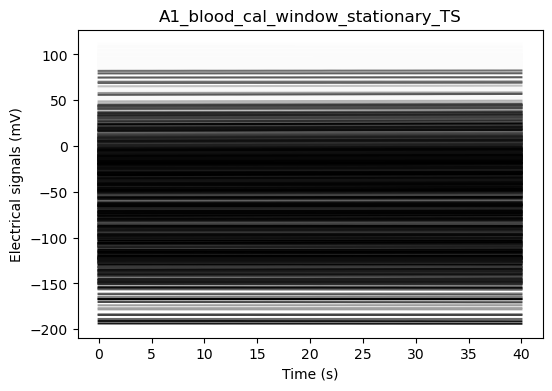

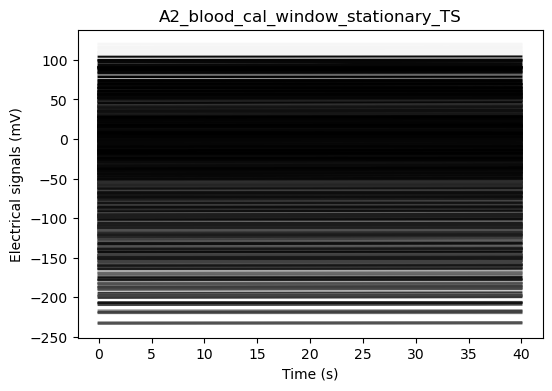

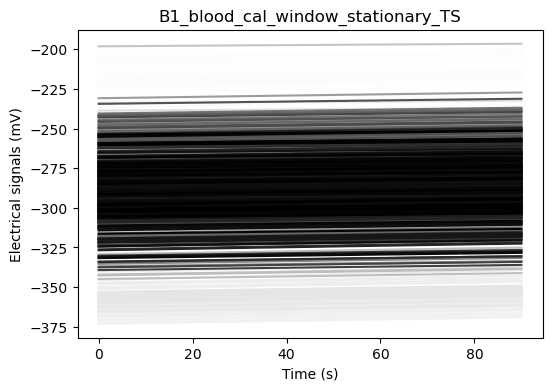

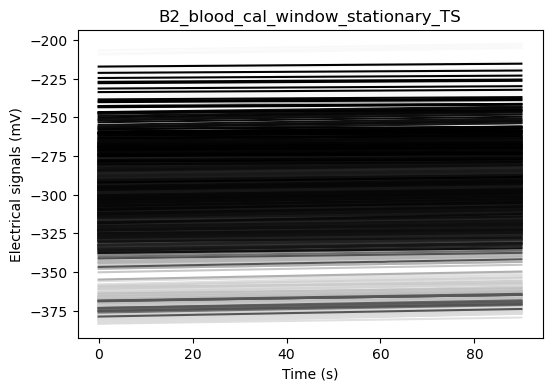

In [30]:
# Cal Window
# Stationary Time Series from Calibration Window before preprocessing (normalization and diferentiation)
A1_blood_cal_window_stationary_index =  adf_A1_blood_cal_window_NormDiff[adf_A1_blood_cal_window_NormDiff['Stationary'] == 'Yes'].index
A1_blood_cal_window_stationary_TS = A1_blood_cal_window[A1_blood_cal_window.index.isin(A1_blood_cal_window_stationary_index)]
plot_all_time_series(A1_blood_cal_window_stationary_TS, 'A1_blood_cal_window_stationary_TS')

A2_blood_cal_window_stationary_index =  adf_A2_blood_cal_window_NormDiff[adf_A2_blood_cal_window_NormDiff['Stationary'] == 'Yes'].index
A2_blood_cal_window_stationary_TS = A2_blood_cal_window[A2_blood_cal_window.index.isin(A2_blood_cal_window_stationary_index)]
plot_all_time_series(A2_blood_cal_window_stationary_TS, 'A2_blood_cal_window_stationary_TS')

B1_blood_cal_window_stationary_index =  adf_B1_blood_cal_window_NormDiff[adf_B1_blood_cal_window_NormDiff['Stationary'] == 'Yes'].index
B1_blood_cal_window_stationary_TS = B1_blood_cal_window[B1_blood_cal_window.index.isin(B1_blood_cal_window_stationary_index)]
plot_all_time_series(B1_blood_cal_window_stationary_TS, 'B1_blood_cal_window_stationary_TS')

B2_blood_cal_window_stationary_index =  adf_B2_blood_cal_window_NormDiff[adf_B2_blood_cal_window_NormDiff['Stationary'] == 'Yes'].index
B2_blood_cal_window_stationary_TS = B2_blood_cal_window[B2_blood_cal_window.index.isin(B2_blood_cal_window_stationary_index)]
plot_all_time_series(B2_blood_cal_window_stationary_TS, 'B2_blood_cal_window_stationary_TS')

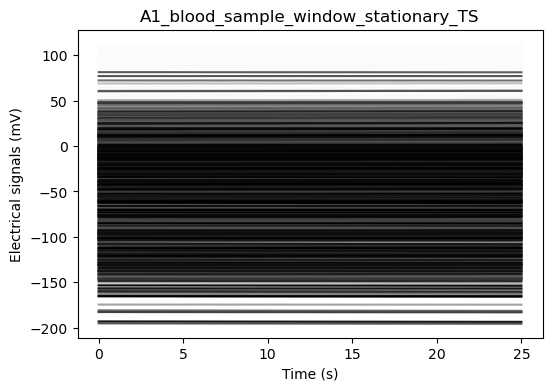

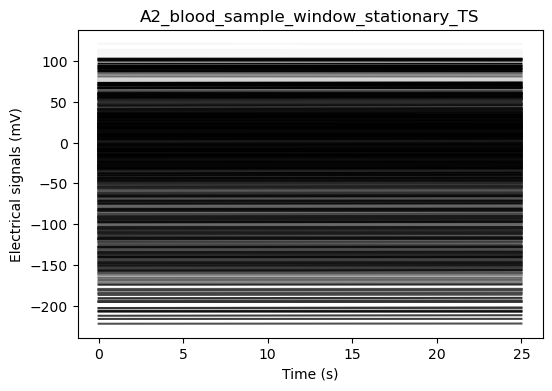

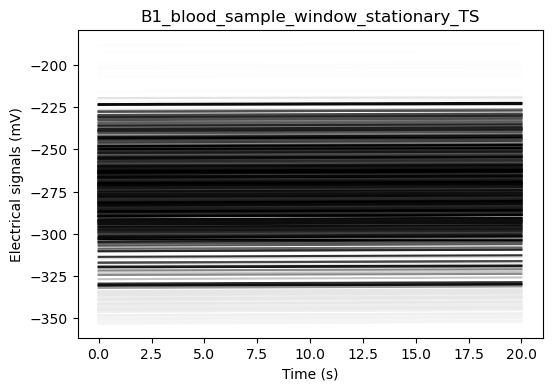

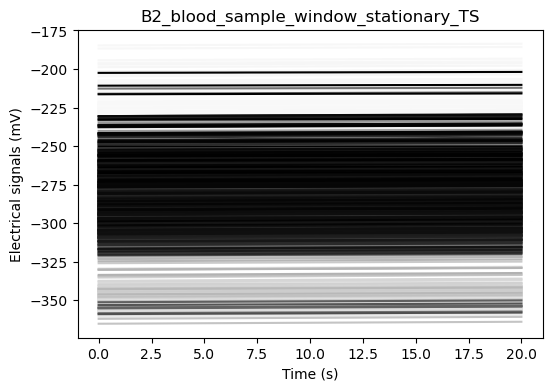

In [31]:
# Sample Window
# Stationary Time Series from Sample Window before preprocessing (normalization and diferentiation)
A1_blood_sample_window_stationary_index =  adf_A1_blood_sample_window_NormDiff[adf_A1_blood_sample_window_NormDiff['Stationary'] == 'Yes'].index
A1_blood_sample_window_stationary_TS = A1_blood_sample_window[A1_blood_sample_window.index.isin(A1_blood_sample_window_stationary_index)]
plot_all_time_series(A1_blood_sample_window_stationary_TS, 'A1_blood_sample_window_stationary_TS')

A2_blood_sample_window_stationary_index =  adf_A2_blood_sample_window_NormDiff[adf_A2_blood_sample_window_NormDiff['Stationary'] == 'Yes'].index
A2_blood_sample_window_stationary_TS = A2_blood_sample_window[A2_blood_sample_window.index.isin(A2_blood_sample_window_stationary_index)]
plot_all_time_series(A2_blood_sample_window_stationary_TS, 'A2_blood_sample_window_stationary_TS')

B1_blood_sample_window_stationary_index =  adf_B1_blood_sample_window_NormDiff[adf_B1_blood_sample_window_NormDiff['Stationary'] == 'Yes'].index
B1_blood_sample_window_stationary_TS = B1_blood_sample_window[B1_blood_sample_window.index.isin(B1_blood_sample_window_stationary_index)]
plot_all_time_series(B1_blood_sample_window_stationary_TS, 'B1_blood_sample_window_stationary_TS')

B2_blood_sample_window_stationary_index =  adf_B2_blood_sample_window_NormDiff[adf_B2_blood_sample_window_NormDiff['Stationary'] == 'Yes'].index
B2_blood_sample_window_stationary_TS = B2_blood_sample_window[B2_blood_sample_window.index.isin(B2_blood_sample_window_stationary_index)]
plot_all_time_series(B2_blood_sample_window_stationary_TS, 'B2_blood_sample_window_stationary_TS')

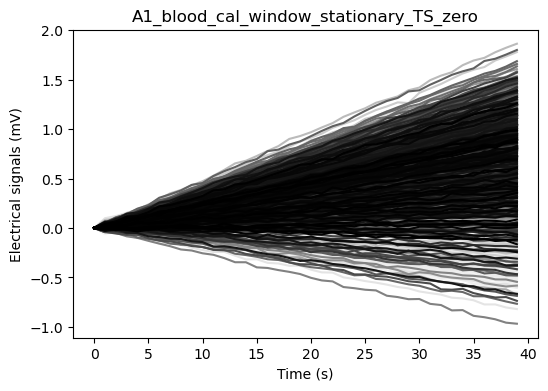

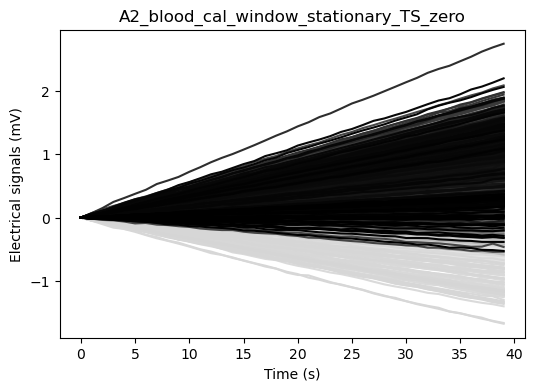

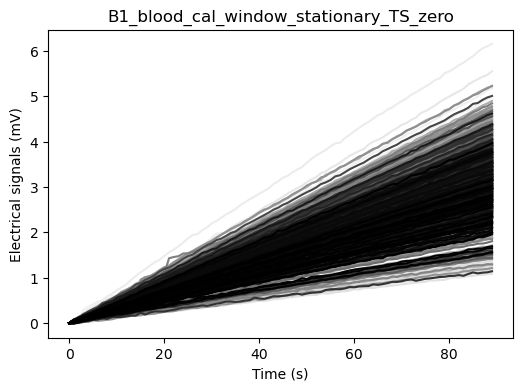

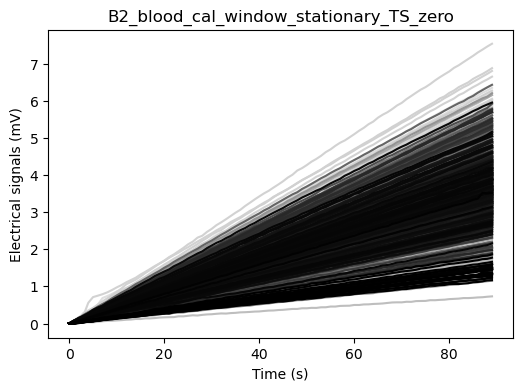

In [32]:
# Cal Window
# Stationary Time Series from Calibration Window after moving to zero start
A1_blood_cal_window_stationary_TS_zero = A1_blood_cal_window_zero[A1_blood_cal_window_zero.index.isin(A1_blood_cal_window_stationary_index)]
plot_all_time_series(A1_blood_cal_window_stationary_TS_zero, 'A1_blood_cal_window_stationary_TS_zero')

A2_blood_cal_window_stationary_TS_zero = A2_blood_cal_window_zero[A2_blood_cal_window_zero.index.isin(A2_blood_cal_window_stationary_index)]
plot_all_time_series(A2_blood_cal_window_stationary_TS_zero, 'A2_blood_cal_window_stationary_TS_zero')

B1_blood_cal_window_stationary_TS_zero = B1_blood_cal_window_zero[B1_blood_cal_window_zero.index.isin(B1_blood_cal_window_stationary_index)]
plot_all_time_series(B1_blood_cal_window_stationary_TS_zero, 'B1_blood_cal_window_stationary_TS_zero')

B2_blood_cal_window_stationary_TS_zero = B2_blood_cal_window_zero[B2_blood_cal_window_zero.index.isin(B2_blood_cal_window_stationary_index)]
plot_all_time_series(B2_blood_cal_window_stationary_TS_zero, 'B2_blood_cal_window_stationary_TS_zero')

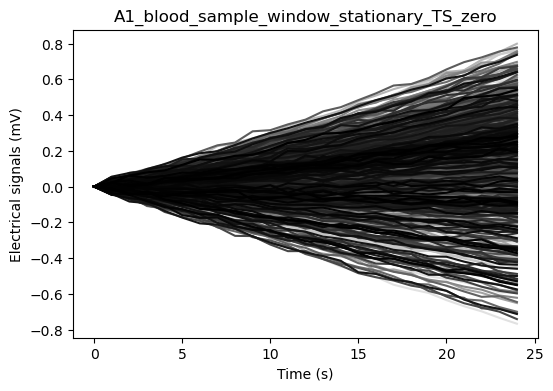

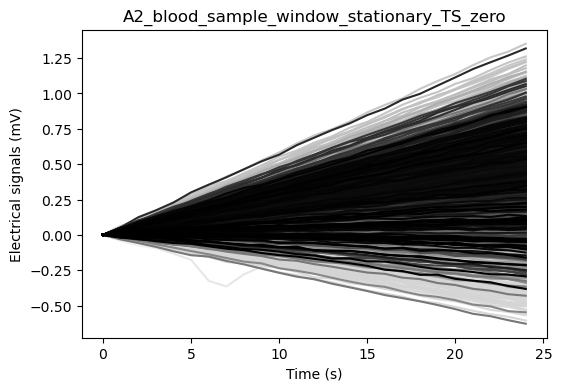

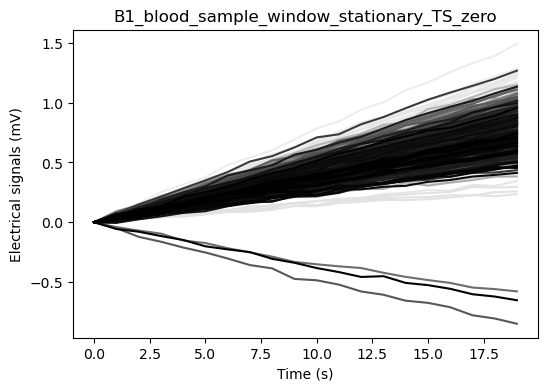

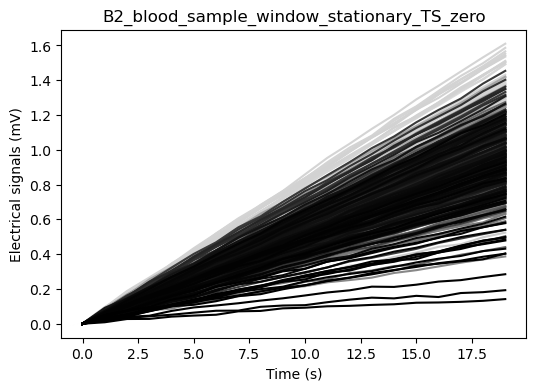

In [33]:
# Sample Window
# Stationary Time Series from Sample Window after moving to zero start
A1_blood_sample_window_stationary_TS_zero = A1_blood_sample_window_zero[A1_blood_sample_window_zero.index.isin(A1_blood_sample_window_stationary_index)]
plot_all_time_series(A1_blood_sample_window_stationary_TS_zero, 'A1_blood_sample_window_stationary_TS_zero')

A2_blood_sample_window_stationary_TS_zero = A2_blood_sample_window_zero[A2_blood_sample_window_zero.index.isin(A2_blood_sample_window_stationary_index)]
plot_all_time_series(A2_blood_sample_window_stationary_TS_zero, 'A2_blood_sample_window_stationary_TS_zero')

B1_blood_sample_window_stationary_TS_zero = B1_blood_sample_window_zero[B1_blood_sample_window_zero.index.isin(B1_blood_sample_window_stationary_index)]
plot_all_time_series(B1_blood_sample_window_stationary_TS_zero, 'B1_blood_sample_window_stationary_TS_zero')

B2_blood_sample_window_stationary_TS_zero = B2_blood_sample_window_zero[B2_blood_sample_window_zero.index.isin(B2_blood_sample_window_stationary_index)]
plot_all_time_series(B2_blood_sample_window_stationary_TS_zero, 'B2_blood_sample_window_stationary_TS_zero')

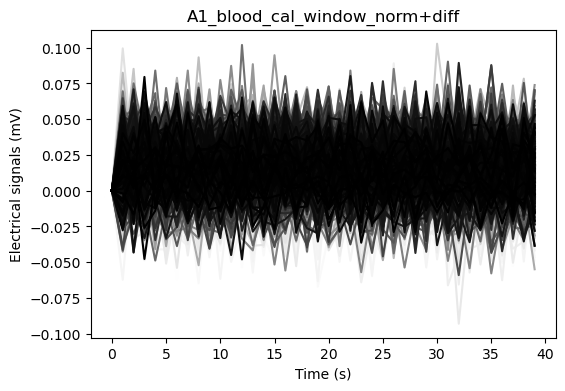

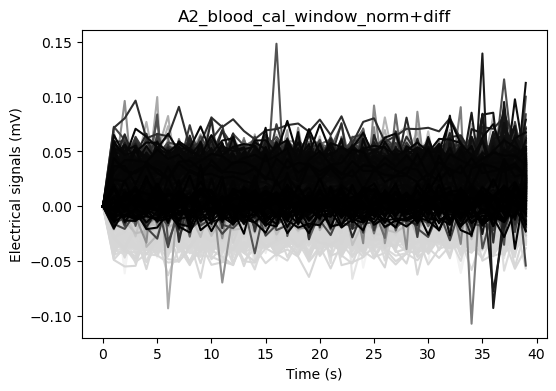

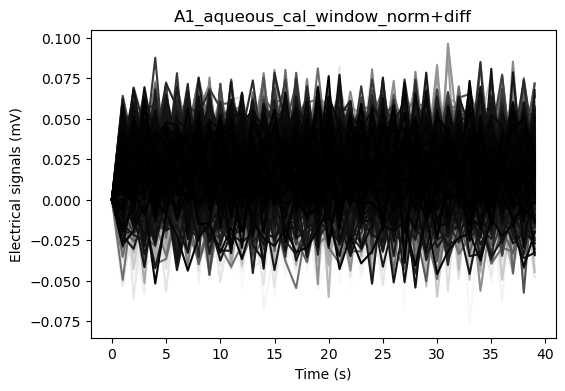

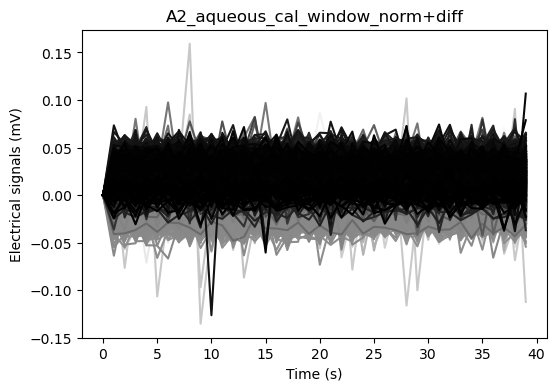

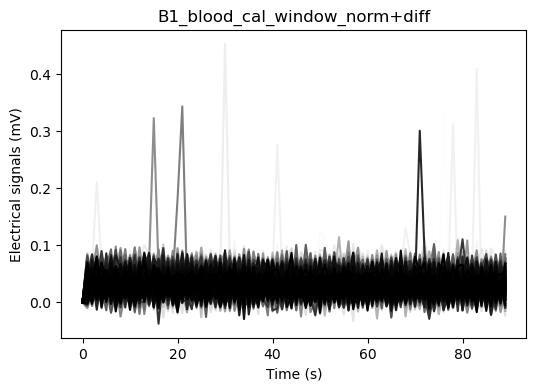

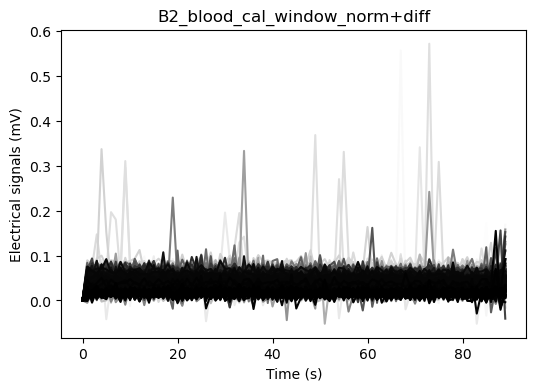

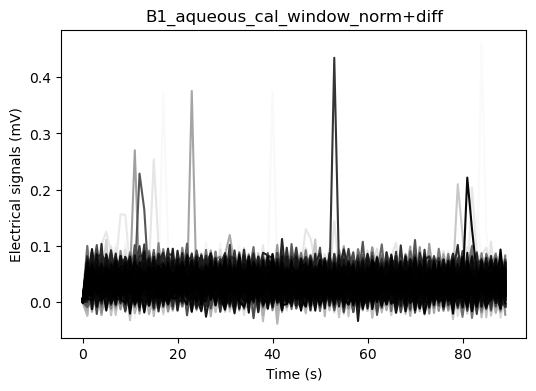

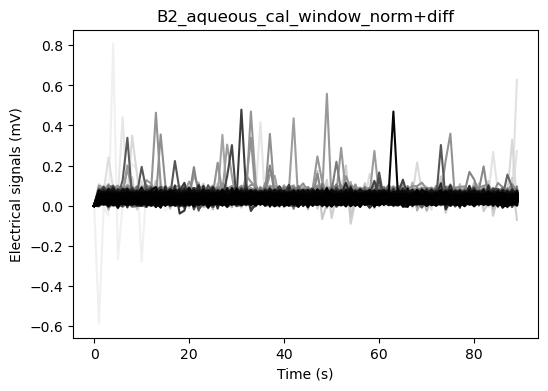

In [34]:
# Cal Window
# Stationary Time Series after preprocessing (normalization and diferentiation)
plot_all_time_series(A1_blood_cal_window_NormDiff2, 'A1_blood_cal_window_norm+diff')
plot_all_time_series(A2_blood_cal_window_NormDiff2, 'A2_blood_cal_window_norm+diff')
plot_all_time_series(A1_aqueous_cal_window_NormDiff2, 'A1_aqueous_cal_window_norm+diff')
plot_all_time_series(A2_aqueous_cal_window_NormDiff2, 'A2_aqueous_cal_window_norm+diff')

plot_all_time_series(B1_blood_cal_window_NormDiff2, 'B1_blood_cal_window_norm+diff')
plot_all_time_series(B2_blood_cal_window_NormDiff2, 'B2_blood_cal_window_norm+diff')
plot_all_time_series(B1_aqueous_cal_window_NormDiff2, 'B1_aqueous_cal_window_norm+diff')
plot_all_time_series(B2_aqueous_cal_window_NormDiff2, 'B2_aqueous_cal_window_norm+diff')

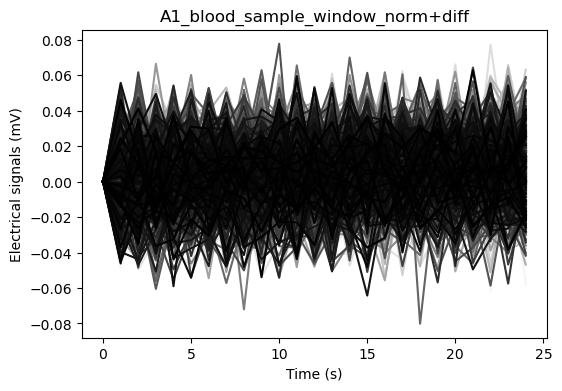

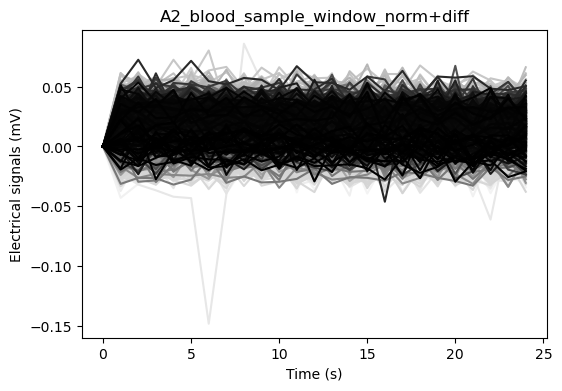

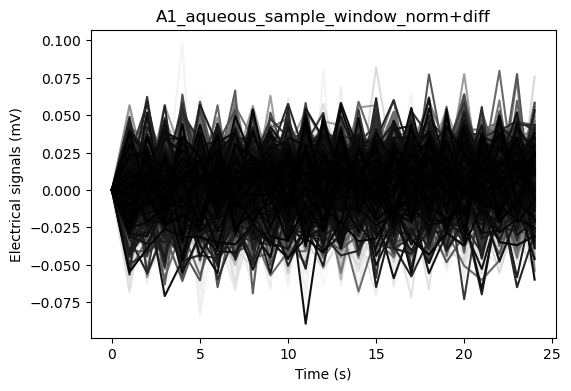

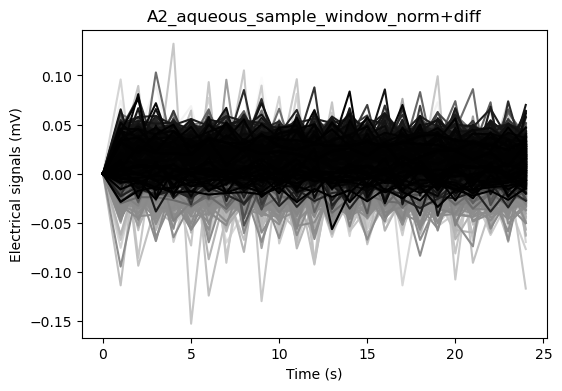

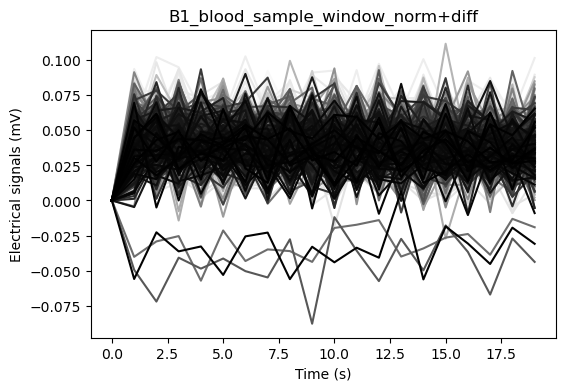

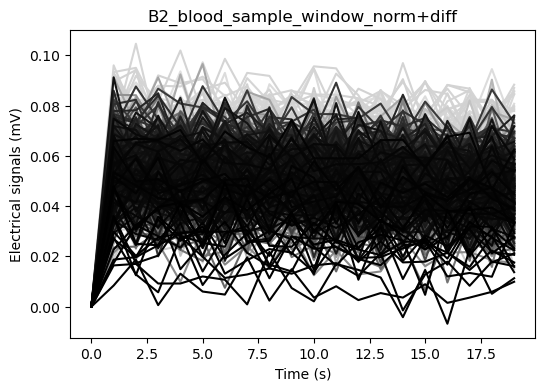

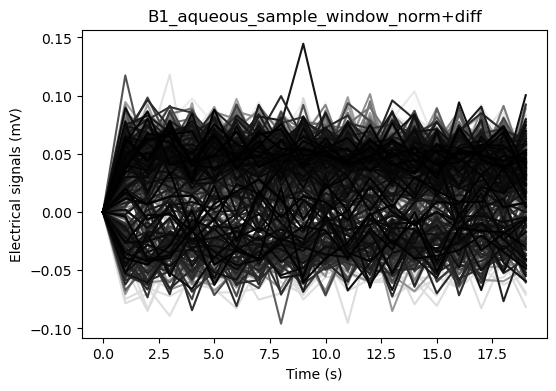

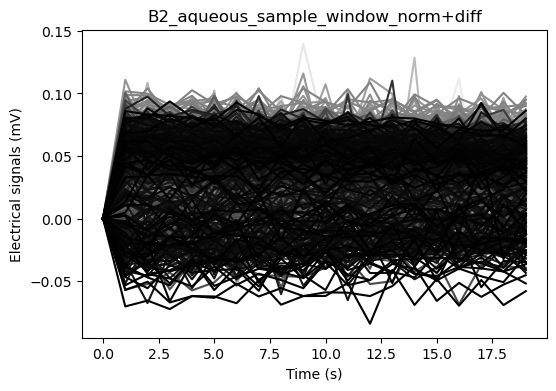

In [35]:
#  Sample Window
plot_all_time_series(A1_blood_sample_window_NormDiff2, 'A1_blood_sample_window_norm+diff')
plot_all_time_series(A2_blood_sample_window_NormDiff2, 'A2_blood_sample_window_norm+diff')
plot_all_time_series(A1_aqueous_sample_window_NormDiff2, 'A1_aqueous_sample_window_norm+diff')
plot_all_time_series(A2_aqueous_sample_window_NormDiff2, 'A2_aqueous_sample_window_norm+diff')

plot_all_time_series(B1_blood_sample_window_NormDiff2, 'B1_blood_sample_window_norm+diff')
plot_all_time_series(B2_blood_sample_window_NormDiff2, 'B2_blood_sample_window_norm+diff')
plot_all_time_series(B1_aqueous_sample_window_NormDiff2, 'B1_aqueous_sample_window_norm+diff')
plot_all_time_series(B2_aqueous_sample_window_NormDiff2, 'B2_aqueous_sample_window_norm+diff')

In [36]:
def compare_variances(data1, data2):
    # Compute the variance of each time series (row-wise variance)
    variance_s1 = data1.var(axis=1)
    variance_s2 = data2.var(axis=1)
    
    # Compute the mean variance for each system
    mean_variance_s1 = variance_s1.mean()
    mean_variance_s2 = variance_s2.mean()
    
    print(f"Mean Variance for System 1: {mean_variance_s1}")
    print(f"Mean Variance for System 2: {mean_variance_s2}")

    # sampleculate standard deviation for each stationary time series
    std_s1 = data1.std(axis=1)
    std_s2 = data2.std(axis=1)

    print(f"Standard Deviation of System 1: {std_s1.mean()}")
    print(f"Standard Deviation of System 2: {std_s2.mean()}")

    # Perform Levene's test to compare variances
    stat_levenne, p_value_levenne = levene(variance_s1, variance_s2)

    print(f"Levene's test statistic: {stat_levenne}")
    print(f"p-value: {p_value_levenne}")

    if p_value_levenne < 0.05:
        print("There is a significant difference in variances.")
    else:
        print("There is no significant difference in variances.")

    #print('\nOther metrics of variability around the mean\n')
    
    # Calculate mean absolute deviation for each time series
    #mad_A1 = data1.apply(lambda x: np.mean(np.abs(x - x.mean())), axis=1)
    #mad_A2 = data2.apply(lambda x: np.mean(np.abs(x - x.mean())), axis=1)
    
    #print(f"Mean Absolute Deviation of System 1: {mad_A1.mean()}")
    #print(f"Mean Absolute Deviation of System 2: {mad_A2.mean()}")
    
    # Calculate RMSE for each time series
    #rmse_A1 = data1.apply(lambda x: np.sqrt(np.mean((x - x.mean())**2)), axis=1)
    #rmse_A2 = data2.apply(lambda x: np.sqrt(np.mean((x - x.mean())**2)), axis=1)
    
    #print(f"RMSE of System 1: {rmse_A1.mean()}")
    #print(f"RMSE of System 2: {rmse_A2.mean()}")
    
    #return {
    #    "mean_variance_s1": mean_variance_s1,
    #    "mean_variance_s2": mean_variance_s2,
    #}


In [37]:
def bootstrap_variance_comparison(time_series_s1, time_series_s2, num_bootstrap=10000, num_timeseries=300):
    bootstrap_variances_s1 = []
    bootstrap_variances_s2 = []

    for _ in range(num_bootstrap):
        sample_s1 = time_series_s1.sample(n=num_timeseries, replace=True)
        sample_s2 = time_series_s2.sample(n=num_timeseries, replace=True)

        variance_s1 = sample_s1.var(axis=1).mean()
        variance_s2 = sample_s2.var(axis=1).mean()

        bootstrap_variances_s1.append(variance_s1)
        bootstrap_variances_s2.append(variance_s2)

    bootstrap_variances_s1 = np.array(bootstrap_variances_s1)
    bootstrap_variances_s2 = np.array(bootstrap_variances_s2)

    mean_variance_s1 = bootstrap_variances_s1.mean()
    mean_variance_s2 = bootstrap_variances_s2.mean()
    std_variance_s1 = bootstrap_variances_s1.std()
    std_variance_s2 = bootstrap_variances_s2.std()

    print(f"Bootstrap Mean Variance for System 1: {mean_variance_s1} ± {std_variance_s1}")
    print(f"Bootstrap Mean Variance for System 2: {mean_variance_s2} ± {std_variance_s2}")

    # Confidence intervals
    ci_s1 = np.percentile(bootstrap_variances_s1, [2.5, 97.5])
    ci_s2 = np.percentile(bootstrap_variances_s2, [2.5, 97.5])

    print(f"95% Confidence Interval for System 1: {ci_s1}")
    print(f"95% Confidence Interval for System 2: {ci_s2}")

    # Perform Levene's test to compare variances of the bootstrap samples
    stat, p_value = levene(bootstrap_variances_s1, bootstrap_variances_s2)

    print(f"Levene's test statistic: {stat}")
    print(f"p-value: {p_value}")

    if p_value < 0.05:
        print("There is a significant difference in variances.")
    else:
        print("There is no significant difference in variances.")

    return mean_variance_s1, mean_variance_s2, ci_s1, ci_s2, bootstrap_variances_s1, bootstrap_variances_s2

def plot_box_plots(bootstrap_variances_s1, bootstrap_variances_s2):
    data = [bootstrap_variances_s1, bootstrap_variances_s2]
    labels = ['System 1', 'System 2']

    fig, ax = plt.subplots()
    ax.boxplot(data, labels=labels, patch_artist=True)
    ax.set_ylabel('Variance')
    ax.set_title('Distribution of Variances for System 1 and System 2')
    plt.show()

# On the Raw Data

In [38]:
# Compute the variance of each time series (row-wise variance, I mean the variance over each TestID)
variance_s1 = A1_blood_cal_window.var(axis=1)
variance_s2 = A2_blood_cal_window.var(axis=1)

# Compute the mean variance for each system
mean_variance_s1 = variance_s1.mean()
mean_variance_s2 = variance_s2.mean()

print(f"Mean Variance for System 1: {mean_variance_s1}")
print(f"Mean Variance for System 2: {mean_variance_s2}")

# F-test to test the null hypothesis that the variances of two populations are equal.
f_statistic = variance_s1.var() / variance_s2.var()
dof1 = len(variance_s1) - 1  # degrees of freedom for system 1
dof2 = len(variance_s2) - 1  # degrees of freedom for system 2

# Calculate the p-value
p_value = f.cdf(f_statistic, dof1, dof2)

print(f"F-Statistic: {f_statistic}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("The difference in variances is statistically significant.")
else:
    print("The difference in variances is not statistically significant.")


variance_s1.describe()
variance_s2.describe()

Mean Variance for System 1: 0.06641073154951417
Mean Variance for System 2: 0.06895955128482723
F-Statistic: 0.6258798319315716
P-Value: 1.57280832546157e-23
The difference in variances is statistically significant.


count    2851.000000
mean        0.068960
std         0.074181
min         0.000024
25%         0.008923
50%         0.046952
75%         0.100903
max         0.709826
dtype: float64

In [39]:
# Calibration Window
print('\nCalibration Window\n')
A_blood_cal_result = compare_variances(A1_blood_cal_window, A2_blood_cal_window)
A_aqueous_cal_result = compare_variances(A1_aqueous_cal_window, A2_aqueous_cal_window)
B_blood_cal_result = compare_variances(B1_blood_cal_window, B2_blood_cal_window)
B_aqueous_cal_result =compare_variances(B1_aqueous_cal_window, B2_aqueous_cal_window)


Calibration Window

Mean Variance for System 1: 0.06641073154951417
Mean Variance for System 2: 0.06895955128482723
Standard Deviation of System 1: 0.2255595755416444
Standard Deviation of System 2: 0.22062120274930205
Levene's test statistic: 20.518296151022533
p-value: 6.067131820150413e-06
There is a significant difference in variances.
Mean Variance for System 1: 0.054755483795489016
Mean Variance for System 2: 0.05376059271322952
Standard Deviation of System 1: 0.1963281694048213
Standard Deviation of System 2: 0.19027420578116158
Levene's test statistic: 0.013984202166783748
p-value: 0.9058692284156671
There is no significant difference in variances.
Mean Variance for System 1: 1.0496999925439199
Mean Variance for System 2: 1.4666742334528193
Standard Deviation of System 1: 1.0009010336238882
Standard Deviation of System 2: 1.1814745343361903
Levene's test statistic: 176.6869006008779
p-value: 1.5424676747364922e-39
There is a significant difference in variances.
Mean Variance f

In [40]:
# Sample Window
print('\nSample Window\n')
A_blood_sample_result = compare_variances(A1_blood_sample_window, A2_blood_sample_window)
A_aqueous_sample_result = compare_variances(A1_aqueous_sample_window, A2_aqueous_sample_window)
B_blood_sample_result = compare_variances(B1_blood_sample_window, B2_blood_sample_window)
B_aqueous_sample_result = compare_variances(B1_aqueous_sample_window, B2_aqueous_sample_window)


Sample Window

Mean Variance for System 1: 0.011821422817445677
Mean Variance for System 2: 0.023245331166835557
Standard Deviation of System 1: 0.09426841806729022
Standard Deviation of System 2: 0.1269297817262393
Levene's test statistic: 284.7927780662581
p-value: 6.52862272864345e-62
There is a significant difference in variances.
Mean Variance for System 1: 0.008277727078926562
Mean Variance for System 2: 0.015948287988569267
Standard Deviation of System 1: 0.07737147540287737
Standard Deviation of System 2: 0.1052167479240689
Levene's test statistic: 336.79809833866227
p-value: 1.804768487478602e-73
There is a significant difference in variances.
Mean Variance for System 1: 0.07513614066177503
Mean Variance for System 2: 0.10442079921166429
Standard Deviation of System 1: 0.2686065189459355
Standard Deviation of System 2: 0.31763842763018013
Levene's test statistic: 72.77403804306908
p-value: 1.9904286826481476e-17
There is a significant difference in variances.
Mean Variance fo

Bootstrap Mean Variance for System 1: 0.06638338538507425 ± 0.003393157289866371
Bootstrap Mean Variance for System 2: 0.06891786259210496 ± 0.004256954102422097
95% Confidence Interval for System 1: [0.05973505 0.07307792]
95% Confidence Interval for System 2: [0.06062152 0.07736497]
Levene's test statistic: 424.499879638642
p-value: 2.383861708489973e-93
There is a significant difference in variances.


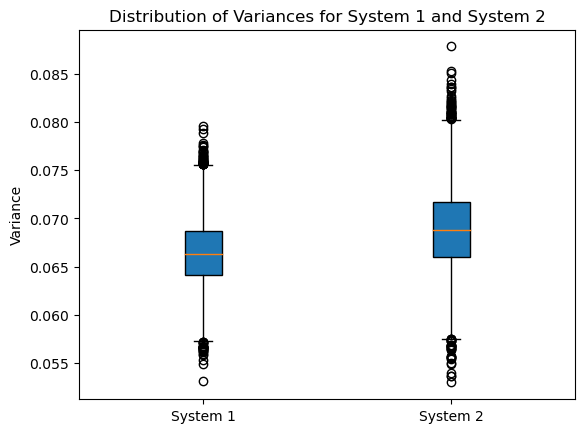

In [41]:
# Bootstrap
mean_variance_s1, mean_variance_s2, ci_s1, ci_s2, bootstrap_variances_s1, bootstrap_variances_s2 = bootstrap_variance_comparison(A1_blood_cal_window, A2_blood_cal_window)
plot_box_plots(bootstrap_variances_s1, bootstrap_variances_s2)


# On the stationary data

In [42]:
# Calibration Window
print('\nCalibration Window\n')
print('\nA1_blood_cal_window vs A2_blood_cal_window\n')
A_blood_cal_NormDiff2 = compare_variances(A1_blood_cal_window_NormDiff2, A2_blood_cal_window_NormDiff2)
print('\nB1_blood_cal_window vs B2_blood_cal_window\n')
B_blood_cal_NormDiff2 = compare_variances(B1_blood_cal_window_NormDiff2, B2_blood_cal_window_NormDiff2)

print('\nA1_aqueous_cal_window vs A2_aqueous_cal_window\n')
A_aqueous_cal_NormDiff2 = compare_variances(A1_aqueous_cal_window_NormDiff2, A2_aqueous_cal_window_NormDiff2)
print('\nB1_aqueous_cal_window vs B2_aqueous_cal_window\n')
B_aqueous_cal_NormDiff2 = compare_variances(B1_aqueous_cal_window_NormDiff2, B2_aqueous_cal_window_NormDiff2)


Calibration Window


A1_blood_cal_window vs A2_blood_cal_window

Mean Variance for System 1: 0.00021000504839200157
Mean Variance for System 2: 8.323891907578327e-05
Standard Deviation of System 1: 0.014321132579308874
Standard Deviation of System 2: 0.008877906352578088
Levene's test statistic: 239.47869533627448
p-value: 1.7108684772224785e-52
There is a significant difference in variances.

B1_blood_cal_window vs B2_blood_cal_window

Mean Variance for System 1: 0.00022125160318817668
Mean Variance for System 2: 9.952619689370222e-05
Standard Deviation of System 1: 0.014684201765747033
Standard Deviation of System 2: 0.00957771782321442
Levene's test statistic: 9.232078698145637
p-value: 0.0023968288362989534
There is a significant difference in variances.

A1_aqueous_cal_window vs A2_aqueous_cal_window

Mean Variance for System 1: 0.00020579766759835013
Mean Variance for System 2: 7.802873311509115e-05
Standard Deviation of System 1: 0.01416699124339781
Standard Deviation of System

In [43]:
# Sample Window
print('\nSample Window\n')
print('\nA1_blood_sample_window vs A2_blood_sample_window\n')
A_blood_sample_NormDiff2 = compare_variances(A1_blood_sample_window_NormDiff2, A2_blood_sample_window_NormDiff2)
print('\nB1_blood_sample_window vs B2_blood_sample_window\n')
B_blood_sample_NormDiff2 = compare_variances(B1_blood_sample_window_NormDiff2, B2_blood_sample_window_NormDiff2)

print('\nA1_aqueous_sample_window vs A2_aqueous_sample_window\n')
A_aqueous_sample_NormDiff2 = compare_variances(A1_aqueous_sample_window_NormDiff2, A2_aqueous_sample_window_NormDiff2)
print('\nB1_aqueous_sample_window vs B2_aqueous_sample_window\n')
B_aqueous_sample_NormDiff2 = compare_variances(B1_aqueous_sample_window_NormDiff2, B2_aqueous_sample_window_NormDiff2)


Sample Window


A1_blood_sample_window vs A2_blood_sample_window

Mean Variance for System 1: 0.00019893377239714572
Mean Variance for System 2: 6.770967792449386e-05
Standard Deviation of System 1: 0.013891217904211363
Standard Deviation of System 2: 0.00804723002069825
Levene's test statistic: 417.8884567685221
p-value: 8.204096122886265e-87
There is a significant difference in variances.

B1_blood_sample_window vs B2_blood_sample_window

Mean Variance for System 1: 0.0002829478426988557
Mean Variance for System 2: 0.00018505024948763736
Standard Deviation of System 1: 0.01663082379200677
Standard Deviation of System 2: 0.013460568576831847
Levene's test statistic: 135.9964020322602
p-value: 2.1899850675927717e-30
There is a significant difference in variances.

A1_aqueous_sample_window vs A2_aqueous_sample_window

Mean Variance for System 1: 0.0002264548459440104
Mean Variance for System 2: 0.00011901440435175032
Standard Deviation of System 1: 0.014686159233237824
Standard Deviati

## Bootstrap on variances from stationary data
- Equal sample size ((I set 1000, as both datasets have more than than number of tests))

- Bootstrapping: Bootstrap with resampling on the time series data from both systems.
    * For each bootstrap sample, we calculate the variance and store it.
- Calculating Statistics: Calculation of the mean and standard deviation of the bootstrap variances for both systems.
- Confidence Intervals: Calculation the 95% confidence intervals for the variances using the percentiles of the bootstrap samples.
- Levene's Test: It performs Levene's test on the bootstrap variances to check for significant differences in variances between the two systems.
    * Can be applied when we are not sure about that the data follows a normal distribution.
    * H0: The variances across the groups are equal.
    * H1: At least one group's variance is different from the others.
    * If the p-value <= alpha, reject the null hypothesis, indicating that there is a significant difference in variances between groups.
    * If the p-value > alpha, fail to reject the null hypothesis, indicating that there is no significant difference in variances between groups.

## Cal Window

Bootstrap Mean Variance for System 1: 0.00020997322747179448 ± 3.9044000233141264e-06
Bootstrap Mean Variance for System 2: 8.322378274514867e-05 ± 2.94351872224431e-06
95% Confidence Interval for System 1: [0.00020238 0.00021789]
95% Confidence Interval for System 2: [7.80440839e-05 8.95880836e-05]
Levene's test statistic: 685.4316953332797
p-value: 1.3962117852943466e-148
There is a significant difference in variances.


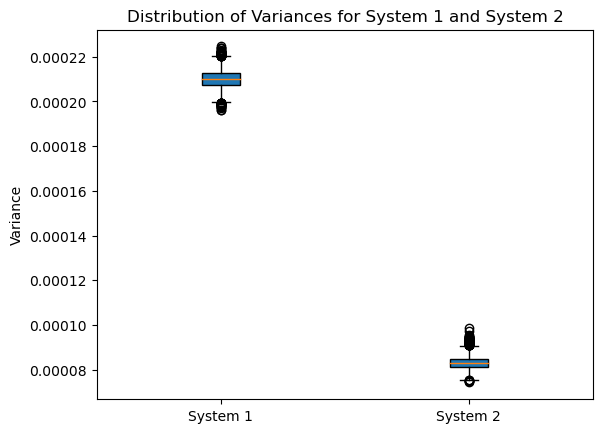

In [44]:
mean_variance_A1_blood_cal_window_Normdiff, mean_variance_A2_blood_cal_window_Normdifff, ci_A1_blood_cal_window_Normdiff, ci_A2_blood_cal_window_Normdiff, bootstrap_variances_A1_blood_cal_window_Normdiff, bootstrap_variances_A2_blood_cal_window_Normdiff = bootstrap_variance_comparison(A1_blood_cal_window_NormDiff2, A2_blood_cal_window_NormDiff2)
plot_box_plots(bootstrap_variances_A1_blood_cal_window_Normdiff, bootstrap_variances_A2_blood_cal_window_Normdiff)

Bootstrap Mean Variance for System 1: 0.00022133665332346752 ± 6.1465971525714995e-06
Bootstrap Mean Variance for System 2: 9.940211345305687e-05 ± 6.906840610727015e-06
95% Confidence Interval for System 1: [0.00021131 0.00023509]
95% Confidence Interval for System 2: [8.95632692e-05 1.16003534e-04]
Levene's test statistic: 74.32310403960926
p-value: 7.11835446900704e-18
There is a significant difference in variances.


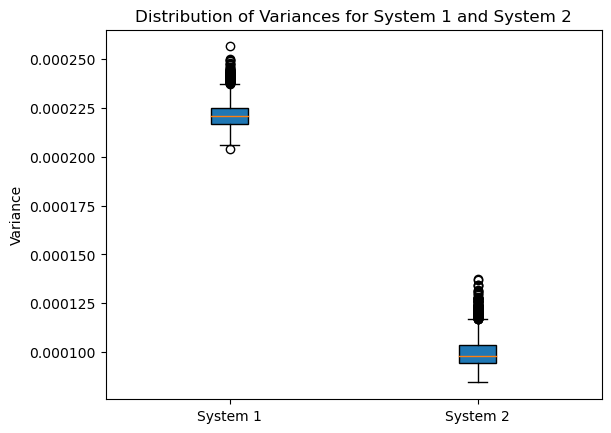

In [45]:
mean_variance_B1_blood_cal_window_Normdiff, mean_variance_B2_blood_cal_window_Normdifff, ci_B1_blood_cal_window_Normdiff, ci_B2_blood_cal_window_Normdiff, bootstrap_variances_B1_blood_cal_window_Normdiff, bootstrap_variances_B2_blood_cal_window_Normdiff = bootstrap_variance_comparison(B1_blood_cal_window_NormDiff2, B2_blood_cal_window_NormDiff2)
plot_box_plots(bootstrap_variances_B1_blood_cal_window_Normdiff, bootstrap_variances_B2_blood_cal_window_Normdiff)


Bootstrap Mean Variance for System 1: 0.00020578886576618744 ± 3.877628977194612e-06
Bootstrap Mean Variance for System 2: 7.80430202620918e-05 ± 3.826075059382087e-06
95% Confidence Interval for System 1: [0.00019823 0.00021356]
95% Confidence Interval for System 2: [7.29052779e-05 8.94047354e-05]
Levene's test statistic: 160.41898891323535
p-value: 1.2670948122797059e-36
There is a significant difference in variances.


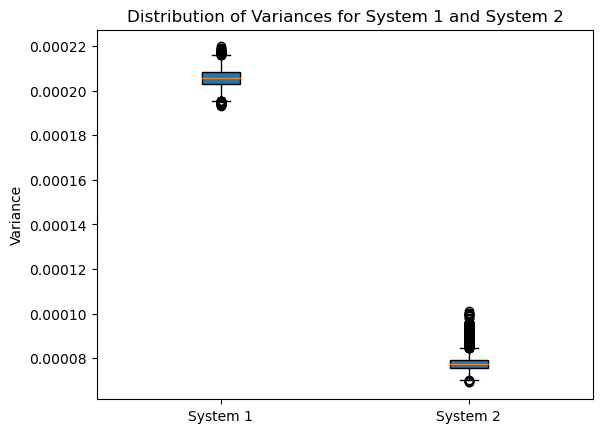

In [46]:
mean_variance_A1_aqueous_cal_window_Normdiff, mean_variance_A2_aqueous_cal_window_Normdifff, ci_A1_aqueous_cal_window_Normdiff, ci_A2_aqueous_cal_window_Normdiff, bootstrap_variances_A1_aqueous_cal_window_Normdiff, bootstrap_variances_A2_aqueous_cal_window_Normdiff = bootstrap_variance_comparison(A1_aqueous_cal_window_NormDiff2, A2_aqueous_cal_window_NormDiff2)
plot_box_plots(bootstrap_variances_A1_aqueous_cal_window_Normdiff, bootstrap_variances_A2_aqueous_cal_window_Normdiff)

Bootstrap Mean Variance for System 1: 0.0002212880889440227 ± 6.133279633617381e-06
Bootstrap Mean Variance for System 2: 0.00010726077990441392 ± 1.578328704670763e-05
95% Confidence Interval for System 1: [0.00021146 0.00023506]
95% Confidence Interval for System 2: [9.11226203e-05 1.53727651e-04]
Levene's test statistic: 1405.7275312752463
p-value: 2.2051217411939087e-297
There is a significant difference in variances.


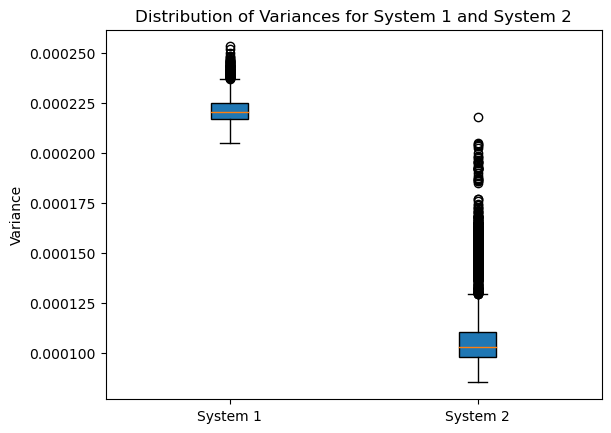

In [47]:
mean_variance_B1_aqueous_cal_window_Normdiff, mean_variance_B2_aqueous_cal_window_Normdifff, ci_B1_aqueous_cal_window_Normdiff, ci_B2_aqueous_cal_window_Normdiff, bootstrap_variances_B1_aqueous_cal_window_Normdiff, bootstrap_variances_B2_aqueous_cal_window_Normdiff = bootstrap_variance_comparison(B1_aqueous_cal_window_NormDiff2, B2_aqueous_cal_window_NormDiff2)
plot_box_plots(bootstrap_variances_B1_aqueous_cal_window_Normdiff, bootstrap_variances_B2_aqueous_cal_window_Normdiff)

## Sample Window

Bootstrap Mean Variance for System 1: 0.0001989911533686912 ± 4.053501754096397e-06
Bootstrap Mean Variance for System 2: 6.771777247726214e-05 ± 2.6823101846215107e-06
95% Confidence Interval for System 1: [0.00019122 0.00020702]
95% Confidence Interval for System 2: [6.39834648e-05 7.43090611e-05]
Levene's test statistic: 1855.3031800249084
p-value: 0.0
There is a significant difference in variances.


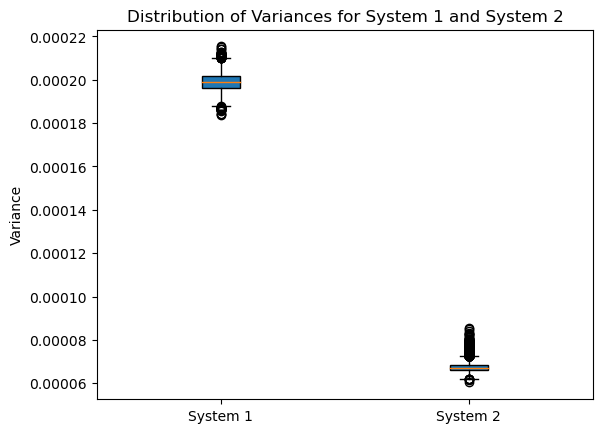

In [48]:
mean_variance_A1_blood_sample_window_Normdiff, mean_variance_A2_blood_sample_window_Normdifff, ci_A1_blood_sample_window_Normdiff, ci_A2_blood_sample_window_Normdiff, bootstrap_variances_A1_blood_sample_window_Normdiff, bootstrap_variances_A2_blood_sample_window_Normdiff = bootstrap_variance_comparison(A1_blood_sample_window_NormDiff2, A2_blood_sample_window_NormDiff2)
plot_box_plots(bootstrap_variances_A1_blood_sample_window_Normdiff, bootstrap_variances_A2_blood_sample_window_Normdiff)

Bootstrap Mean Variance for System 1: 0.000282914046949056 ± 4.935197722285558e-06
Bootstrap Mean Variance for System 2: 0.0001849840450224469 ± 3.1701841845896768e-06
95% Confidence Interval for System 1: [0.00027323 0.00029255]
95% Confidence Interval for System 2: [0.00017889 0.0001913 ]
Levene's test statistic: 1557.725264534577
p-value: 0.0
There is a significant difference in variances.


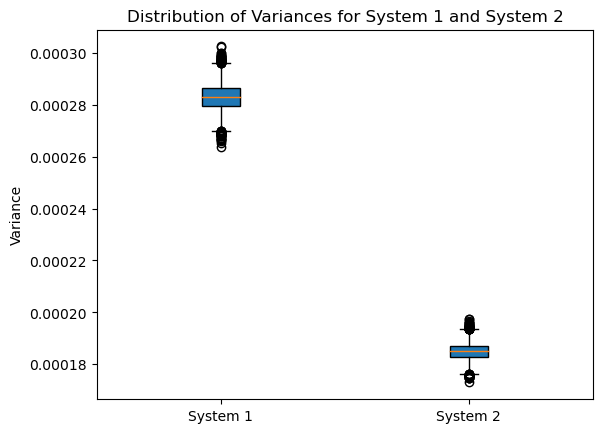

In [49]:
mean_variance_B1_blood_sample_window_Normdiff, mean_variance_B2_blood_sample_window_Normdifff, ci_B1_blood_sample_window_Normdiff, ci_B2_blood_sample_window_Normdiff, bootstrap_variances_B1_blood_sample_window_Normdiff, bootstrap_variances_B2_blood_sample_window_Normdiff = bootstrap_variance_comparison(B1_blood_sample_window_NormDiff2, B2_blood_sample_window_NormDiff2)
plot_box_plots(bootstrap_variances_B1_blood_sample_window_Normdiff, bootstrap_variances_B2_blood_sample_window_Normdiff)

Bootstrap Mean Variance for System 1: 0.00022644396659932237 ± 6.508278117603603e-06
Bootstrap Mean Variance for System 2: 0.00011904743766643135 ± 8.160181294919156e-06
95% Confidence Interval for System 1: [0.00021431 0.00023993]
95% Confidence Interval for System 2: [0.00010483 0.00013666]
Levene's test statistic: 379.1202078591819
p-value: 1.1513534956214434e-83
There is a significant difference in variances.


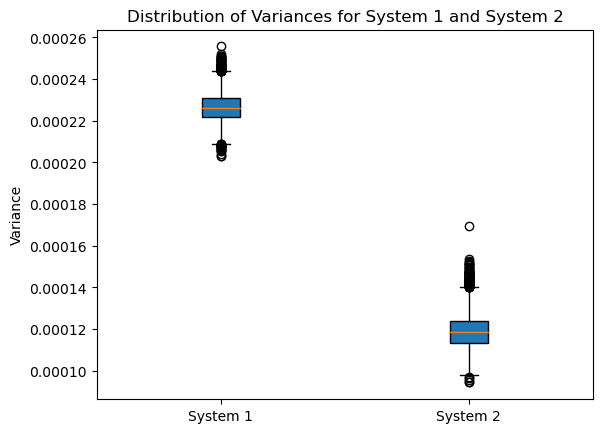

In [50]:
mean_variance_A1_aqueous_sample_window_Normdiff, mean_variance_A2_aqueous_sample_window_Normdifff, ci_A1_aqueous_sample_window_Normdiff, ci_A2_aqueous_sample_window_Normdiff, bootstrap_variances_A1_aqueous_sample_window_Normdiff, bootstrap_variances_A2_aqueous_sample_window_Normdiff = bootstrap_variance_comparison(A1_aqueous_sample_window_NormDiff2, A2_aqueous_sample_window_NormDiff2)
plot_box_plots(bootstrap_variances_A1_aqueous_sample_window_Normdiff, bootstrap_variances_A2_aqueous_sample_window_Normdiff)

Bootstrap Mean Variance for System 1: 0.0002967826046584148 ± 5.677077730830397e-06
Bootstrap Mean Variance for System 2: 0.00020691569217753312 ± 5.205921809106216e-06
95% Confidence Interval for System 1: [0.00028569 0.00030794]
95% Confidence Interval for System 2: [0.00019712 0.00021756]
Levene's test statistic: 70.78321914138307
p-value: 4.2516915578390855e-17
There is a significant difference in variances.


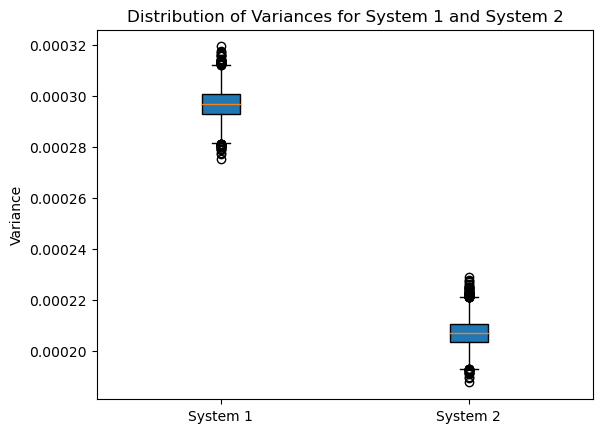

In [51]:
mean_variance_B1_aqueous_sample_window_Normdiff, mean_variance_B2_aqueous_sample_window_Normdifff, ci_B1_aqueous_sample_window_Normdiff, ci_B2_aqueous_sample_window_Normdiff, bootstrap_variances_B1_aqueous_sample_window_Normdiff, bootstrap_variances_B2_aqueous_sample_window_Normdiff = bootstrap_variance_comparison(B1_aqueous_sample_window_NormDiff2, B2_aqueous_sample_window_NormDiff2)
plot_box_plots(bootstrap_variances_B1_aqueous_sample_window_Normdiff, bootstrap_variances_B2_aqueous_sample_window_Normdiff)

In [52]:
# Autocorrelation

In [53]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(B1_aqueous_sample_window_NormDiff2.iloc[0], lags=[14], return_df=True)

,lb_stat,lb_pvalue
14,26.453694,0.022652


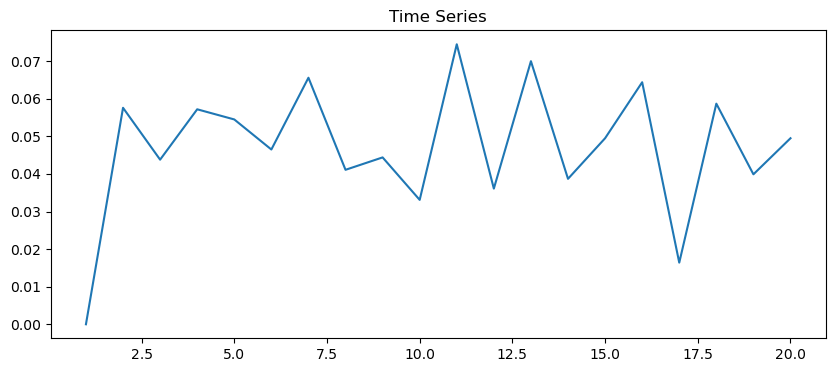

<Figure size 1000x400 with 0 Axes>

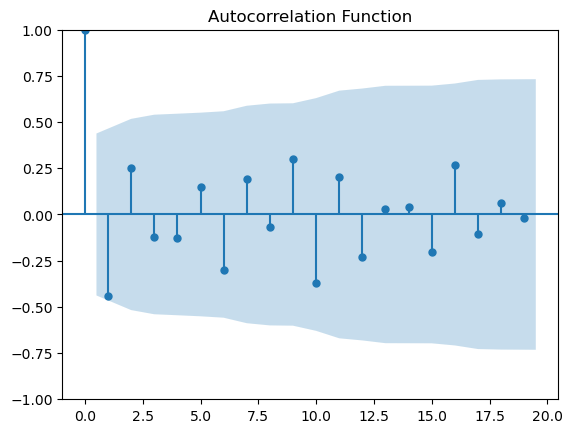

<Figure size 1000x400 with 0 Axes>

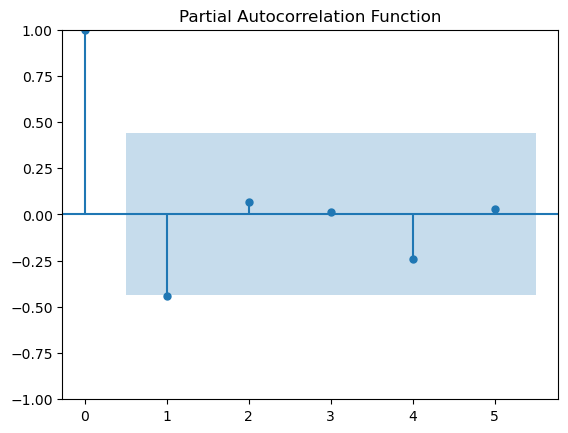

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
# Plot the time series
time_series = B1_aqueous_sample_window_NormDiff2.iloc[0]
plt.figure(figsize=(10, 4))
plt.plot(time_series)
plt.title('Time Series')
plt.show()

# Plot Autocorrelation Function (ACF)
plt.figure(figsize=(10, 4))
plot_acf(time_series, lags=19)
plt.title('Autocorrelation Function')
plt.show()

# Plot Partial Autocorrelation Function (PACF)
plt.figure(figsize=(10, 4))
plot_pacf(time_series, lags=5, method='ywm')
plt.title('Partial Autocorrelation Function')
plt.show()